# Figure 1 - CNN model predicability of itself and across datasets
-----

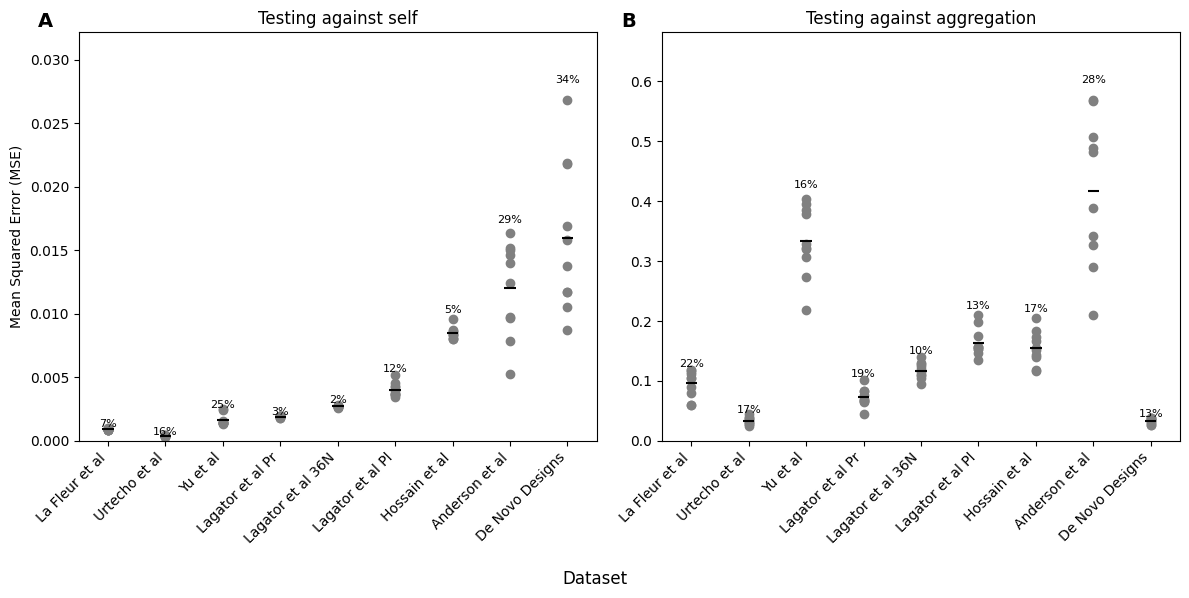

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# -------------------- Data Preprocessing Functions --------------------

def combine_columns(df):
    X = df['Promoter Sequence'].astype(str)
    y = df['Normalized Observed log(TX/Txref)']
    return X, y

def padded_one_hot_encode(seq):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    return [mapping[n.upper()] for n in seq]

def preprocess_sequences(X, max_length=150):
    return np.array([padded_one_hot_encode(seq.zfill(max_length)) for seq in X])

# -------------------- Data Splitting Function --------------------

def split_data_by_file(df):
    file_names = df['File Name'].unique()
    split_data = {name: {} for name in file_names}
    split_data['all'] = {}

    for name in list(file_names) + ['all']:
        subset = df if name == 'all' else df[df['File Name'] == name]
        X, y = combine_columns(subset)
        X = preprocess_sequences(X)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        split_data[name].update({'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test})

    return split_data, file_names

# -------------------- Load Evaluation Metrics --------------------

def load_repeat_evaluate(csv_path):
    df = pd.read_csv(csv_path, index_col=0)
    results = {}
    for col in df.columns:
        if ' (Self)' in col:
            key = col.replace(' (Self)', '')
            results[key] = list(zip(df[f'{key} (Self)'], df[f'{key} (All)']))
    return results

# -------------------- Main Execution --------------------

df = pd.read_csv('Data/LaFleur_supp.csv')
split_data, file_names = split_data_by_file(df)
all_results = load_repeat_evaluate('Data/repeat_evalute_each_file.csv')

file_order = [
    'La Fleur et al', 'Urtecho et al', 'Yu et al', 'Lagator et al Pr',
    'Lagator et al 36N', 'Lagator et al Pl', 'Hossain et al',
    'Anderson et al', 'De Novo Designs'
]
file_order = [f for f in file_order if f in file_names]
x = np.arange(len(file_order))

# Calculate averages and coefficient of variation (CV)
avg_results = {f: np.mean(all_results[f], axis=0) for f in file_names}
avg_train = {f: res[0] for f, res in avg_results.items()}
avg_all = {f: res[1] for f, res in avg_results.items()}

cv_train = {f: np.std([r[0] for r in all_results[f]]) / avg_train[f] for f in file_names}
cv_all = {f: np.std([r[1] for r in all_results[f]]) / avg_all[f] for f in file_names}

# Extract MSEs
train_mse = {f: [r[0] for r in all_results[f]] for f in file_order}
all_mse = {f: [r[1] for r in all_results[f]] for f in file_order}
avg_train_list = [avg_train[f] for f in file_order]
avg_all_list = [avg_all[f] for f in file_order]

# -------------------- Plotting --------------------

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for i, file in enumerate(file_order):
    ax1.scatter([x[i]] * len(train_mse[file]), train_mse[file], color='grey')
    ax1.hlines(avg_train_list[i], x[i] - 0.1, x[i] + 0.1, colors='black')
    ax1.text(x[i], max(train_mse[file]) * 1.05, f'{int(cv_train[file]*100)}%', ha='center', fontsize=8, color='black')

ax1.set_xticks(x, file_order, rotation=45, ha='right')
ax1.set_ylabel('Mean Squared Error (MSE)')
ax1.set_title('Testing against self')
ax1.set_ylim(0, max(map(max, train_mse.values())) * 1.2)

ax1.text(-0.05, 1.05, "A", transform=ax1.transAxes, ha='right', va='top', fontsize=14, fontweight='bold')

for i, file in enumerate(file_order):
    ax2.scatter([x[i]] * len(all_mse[file]), all_mse[file], color='grey')
    ax2.hlines(avg_all_list[i], x[i] - 0.1, x[i] + 0.1, colors='black')
    ax2.text(x[i], max(all_mse[file]) * 1.05, f'{int(cv_all[file]*100)}%', ha='center', fontsize=8)

ax2.set_xticks(x, file_order, rotation=45, ha='right')
ax2.set_title('Testing against aggregation')
ax2.set_ylim(0, max(map(max, all_mse.values())) * 1.2)

ax2.text(-0.05, 1.05, "B", transform=ax2.transAxes, ha='right', va='top', fontsize=14, fontweight='bold', color='black')

fig.supxlabel("Dataset")
plt.tight_layout()
plt.show()

# Save the figure
fig.savefig('Figures/Figure1.pdf', dpi=300, bbox_inches='tight')

# Figure 2 - CNN construction integrating multiple datasets
-----

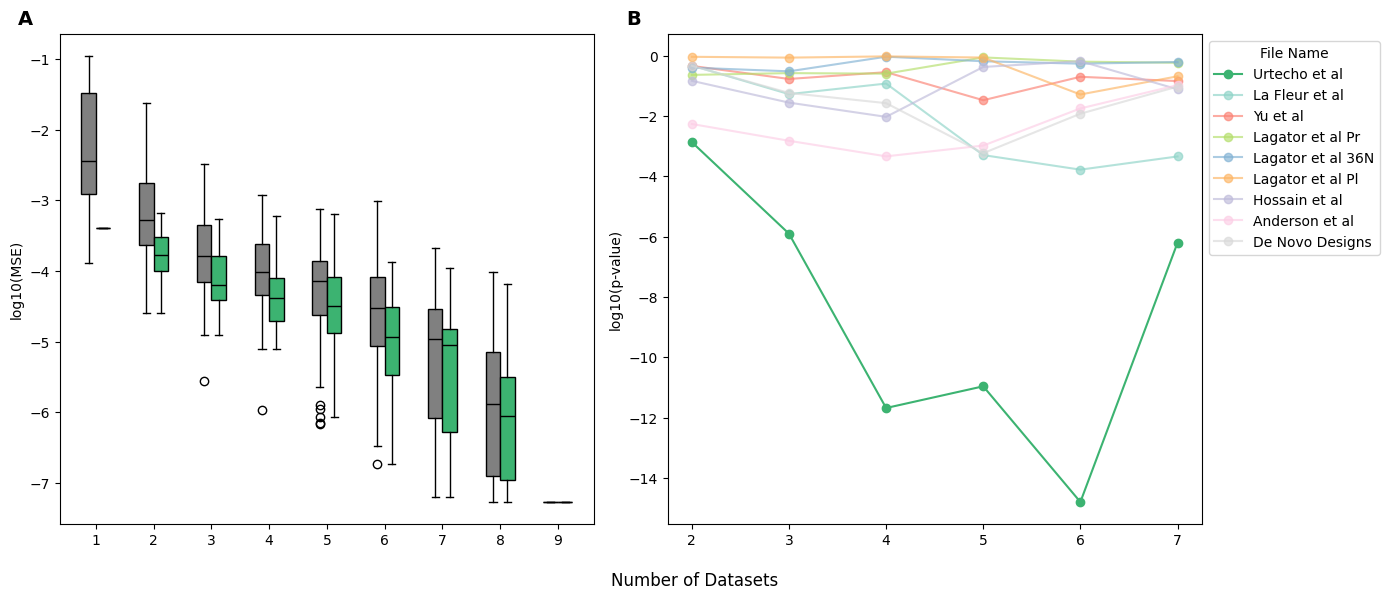

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# ---------------- Load and Prepare Data --------------------
file_names = pd.read_csv('Data/LaFleur_supp.csv')['File Name'].unique()
target_files = ['Urtecho et al']

data_df = pd.read_csv('Data/data_comparison.csv')
data = data_df[['Number of Files', 'MSE', 'Name']].values

# ---------------- P-Value Calculation --------------------
def get_file_mse(data):
    return {
        tuple(sorted(combo.split(', '))): mse 
        for _, mse, combo in data
    }

def calculate_pvalues(file_names, combo_to_mse, start=2, end=7):
    p_values = {file: {} for file in file_names}
    for size in range(start, end + 1):
        combos = {k: v for k, v in combo_to_mse.items() if len(k) == size}
        for file in file_names:
            include = [v for k, v in combos.items() if file in k]
            exclude = [v for k, v in combos.items() if file not in k]
            if len(include) > 1 and len(exclude) > 1:
                _, p = ttest_ind(include, exclude, equal_var=False)
                p_values[file][f'{size}'] = p
            else:
                p_values[file][f'{size}'] = np.nan
    return pd.DataFrame(p_values).T.reset_index().rename(columns={'index': 'File Name'})

def reshape_for_plotting(df):
    df_long = df.melt(id_vars='File Name', var_name='Num_Datasets', value_name='p_value')
    df_long['Num_Datasets'] = df_long['Num_Datasets'].astype(int)
    df_long['log10_p_value'] = np.log10(df_long['p_value'].replace(0, np.nan))
    return df_long

combo_to_mse = get_file_mse(data)
df_pvalues = calculate_pvalues(file_names, combo_to_mse)
df_long = reshape_for_plotting(df_pvalues)

# ---------------- Plotting --------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharex=False)

# --- Subplot 1: MSE Boxplots ---

# Define bold colors for target files
bold_colors = {'Urtecho et al': 'mediumseagreen'}
muted_colors = {name: plt.cm.Set3(i) for i, name in enumerate(file_names) if name not in bold_colors}

colors = {**bold_colors, **muted_colors}

x_all = sorted(set(int(n) for n, _, _ in data))

labeled=True
offset = 0.125
for x in x_all:
    y_vals = [l for n, l, combo in data if int(n) == x]
    ax1.boxplot([y_vals], positions=[x - offset], widths=0.25, patch_artist=True,
                   boxprops=dict(facecolor='grey'),
                   medianprops=dict(color='black'), 
                   label="All combinations" if labeled else None)
    labeled=False
    for i, file_name in enumerate(target_files):
        y_vals = [l for n, l, combo in data if int(n) == x and file_name in str(combo)]
        if not y_vals:
            continue

        # Offset x slightly for visual separation
        ax1.boxplot([y_vals], positions=[x + offset], widths=0.25, patch_artist=True,
                   boxprops=dict(facecolor=colors[file_name]), showfliers=False,
                   medianprops=dict(color='black'),
                   label=f"With {file_name}" if x == x_all[0] else None)

ax1.set_xticks(x_all)
ax1.set_xticklabels(x_all)

ax1.set_ylabel('log10(MSE)')
# ax1.legend()
ax1.text(-0.05, 1.05, "A", transform=ax1.transAxes, ha='right', va='top', fontsize=14, fontweight='bold')

# --- Subplot 2: P-Values Plot ---
file_order = [
    'Urtecho et al', 'La Fleur et al', 'Yu et al', 'Lagator et al Pr',
    'Lagator et al 36N', 'Lagator et al Pl', 'Hossain et al',
    'Anderson et al', 'De Novo Designs'
]
for file in file_order:
    if file not in df_long['File Name'].values:
        continue
    group = df_long[df_long['File Name'] == file]
    ax2.plot(
        group['Num_Datasets'],
        group['log10_p_value'],
        marker='o',
        label=file,
        color=colors[file],
        alpha=1 if file in target_files else 0.65,
    )

ax2.set_ylabel('log10(p-value)')
ax2.legend(title='File Name', loc='upper left', bbox_to_anchor=(1, 1))

ax2.text(-0.05, 1.05, "B", transform=ax2.transAxes, ha='right', va='top', fontsize=14, fontweight='bold')

fig.supxlabel("Number of Datasets")

plt.tight_layout()
plt.show()


# Save the figure
fig.savefig('Figures/Figure2.pdf', dpi=300, bbox_inches='tight')

# Figure 3 - Comparison of Heuristic and Hyperparameter Model

-----

305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


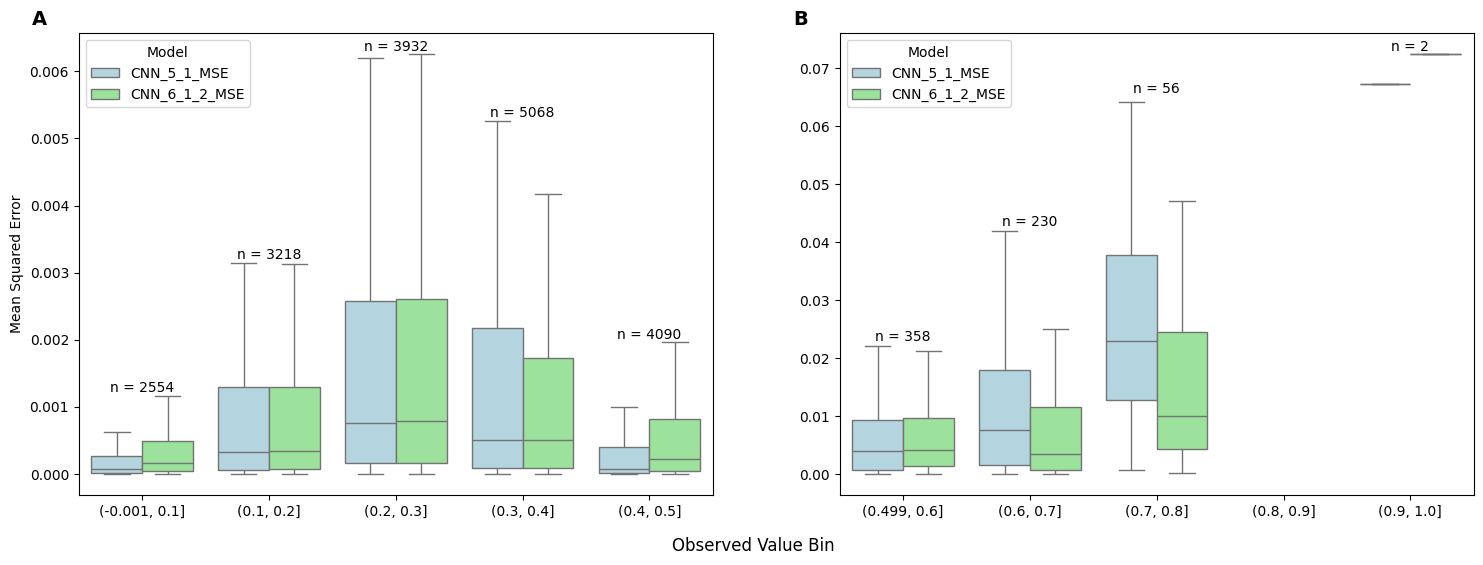

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model  # type: ignore

# -------------------- Data Preprocessing Functions --------------------

def combine_columns(df):
    X = df['Promoter Sequence'].astype(str)
    y = MinMaxScaler().fit_transform(df[['Observed log(TX/Txref)']].abs())
    return X, y

def padded_one_hot_encode(seq):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    return [mapping[n.upper()] for n in seq]

def preprocess_sequences(X, max_length=150):
    return np.array([padded_one_hot_encode(seq.zfill(max_length)) for seq in X])

# -------------------- Load and Preprocess Data --------------------

df = pd.read_csv('Data/LaFleur_supp.csv')
x, y = combine_columns(df)
X = preprocess_sequences(x)
_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

CNN_5_1 = load_model('Models/CNN_5_1.keras')
CNN_6_1_2 = load_model('Models/CNN_6_1_2.keras')

df = pd.DataFrame({
    'Observed': y_test.flatten(),
    'CNN_5_1_pred': CNN_5_1.predict(X_test).flatten(),
    'CNN_6_1_2_pred': CNN_6_1_2.predict(X_test).flatten(),
})

df['CNN_5_1_MSE'] = (df['Observed'] - df['CNN_5_1_pred']) ** 2
df['CNN_6_1_2_MSE'] = (df['Observed'] - df['CNN_6_1_2_pred']) ** 2

# -------------------- Plotting MSE Distributions --------------------

bins_low = np.linspace(0, 0.5, 6)
bins_high = np.linspace(0.5, 1, 6)
df['Observed_bin_low'] = pd.cut(df['Observed'], bins_low, include_lowest=True)
df['Observed_bin_high'] = pd.cut(df['Observed'], bins_high, include_lowest=True)

mse_columns = ['CNN_5_1_MSE', 'CNN_6_1_2_MSE']
mse_data_low = pd.melt(
    df,
    id_vars=['Observed_bin_low'],
    value_vars=mse_columns,
    var_name='Model',
    value_name='MSE'
)
mse_data_high = pd.melt(
    df,
    id_vars=['Observed_bin_high'],
    value_vars=mse_columns,
    var_name='Model',
    value_name='MSE'
)

# -------------------- Plotting MSE Distributions as Subplots --------------------

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Count number of samples per bin
counts_low = mse_data_low.groupby('Observed_bin_low', observed=False).size()
counts_high = mse_data_high.groupby('Observed_bin_high', observed=False).size()

# Plot for observed bins < 0.5
sns.boxplot(
    x='Observed_bin_low',
    y='MSE',
    hue='Model',
    data=mse_data_low,
    palette=['lightblue', 'lightgreen'],
    showfliers=False,
    ax=axes[0],
)
axes[0].set_xlabel('')
axes[0].set_ylabel('Mean Squared Error')

# Compute Q3 + 1.5*IQR (upper whisker)
q3_iqr_low = mse_data_low.groupby(['Observed_bin_low', 'Model'], observed=True)['MSE'].agg(
    q3=lambda x: x.quantile(0.75),
    iqr=lambda x: x.quantile(0.75) - x.quantile(0.25)
).reset_index()
q3_iqr_low['upper_whisker'] = q3_iqr_low['q3'] + 1.5 * q3_iqr_low['iqr']
max_whiskers_low = q3_iqr_low.groupby('Observed_bin_low', observed=False)['upper_whisker'].max()

# Annotate above whisker
for i, (bin_label, count) in enumerate(counts_low.items()):
    whisker_top = max_whiskers_low.get(bin_label, 0)
    axes[0].text(i, whisker_top, f'n = {count}', ha='center', va='bottom', fontsize=10)

# Plot for observed bins > 0.5
sns.boxplot(
    x='Observed_bin_high',
    y='MSE',
    hue='Model',
    data=mse_data_high,
    palette=['lightblue', 'lightgreen'],
    showfliers=False,
    ax=axes[1],
)
axes[1].set_xlabel('')
axes[1].set_ylabel('')

q3_iqr_high = mse_data_high.groupby(['Observed_bin_high', 'Model'], observed=True)['MSE'].agg(
    q3=lambda x: x.quantile(0.75),
    iqr=lambda x: x.quantile(0.75) - x.quantile(0.25)
).reset_index()
q3_iqr_high['upper_whisker'] = q3_iqr_high['q3'] + 1.5 * q3_iqr_high['iqr']
max_whiskers_high = q3_iqr_high.groupby('Observed_bin_high', observed=False)['upper_whisker'].max()

for i, (bin_label, count) in enumerate(counts_high.items()):
    whisker_top = max_whiskers_high.get(bin_label, np.nan)
    if np.isfinite(whisker_top):
        offset = -0.01 if i == 2 else 0
        axes[1].text(i, whisker_top + offset, f'n = {count}', ha='center', va='bottom', fontsize=10)

fig.supxlabel('Observed Value Bin')

axes[0].text(-0.05, 1.05, "A", transform=axes[0].transAxes, ha='right', va='top', fontsize=14, fontweight='bold')
axes[1].text(-0.05, 1.05, "B", transform=axes[1].transAxes, ha='right', va='top', fontsize=14, fontweight='bold')

plt.savefig('Figures/Figure3.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Figure 4 - Expression normalized Saliency Map of datasets

--------

/var/folders/c5/00kj5vrd7qd3b5q3c79llp540000gn/T/ipykernel_73624/3762125595.py:164: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


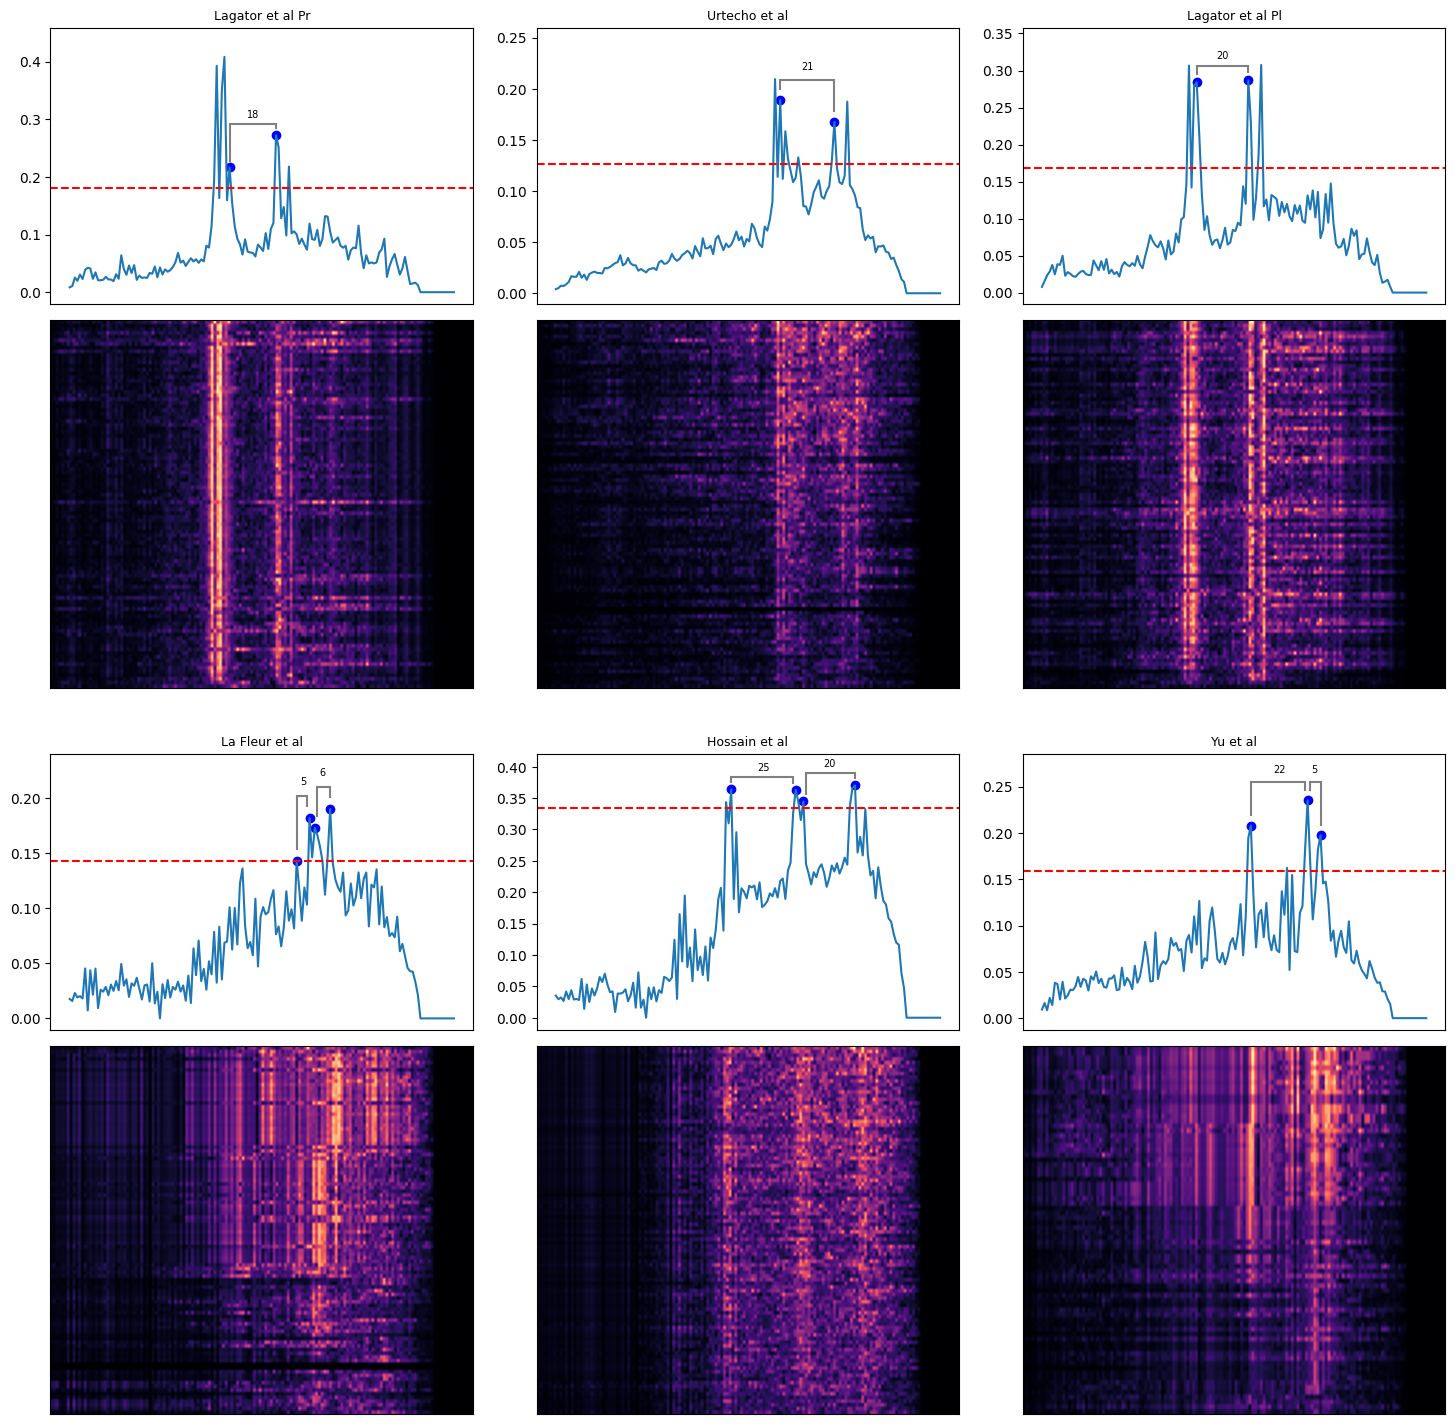

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model  # type: ignore
from scipy.signal import find_peaks
import matplotlib.gridspec as gridspec

# -------------------- Data Preprocessing Functions --------------------

def padded_one_hot_encode(seq):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    return [mapping[n.upper()] for n in seq]

# ----------------------- Generate Saliency Maps -----------------------

def generate_saliency_map(model, sequence):
    input_tensor = tf.convert_to_tensor(sequence[np.newaxis, ...], dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        prediction = model(input_tensor)[0, 0]
    gradient = tape.gradient(prediction, input_tensor)
    gradient = tf.norm(gradient, axis=-1)
    return (gradient / tf.reduce_max(gradient)).numpy()

def plot_saliency_map_grid_combined(
    model_filename,
    sequences,
    ax_line=None,
    ax_imshow=None,
    file_name=None,
    colorbar=False,
):
    model = load_model(model_filename)
    saliency_maps = []
    predictions = []

    for seq in sequences:
        pred = model(tf.convert_to_tensor(seq[np.newaxis, ...], dtype=tf.float32))[0, 0].numpy()
        saliency = np.abs(generate_saliency_map(model, seq)).flatten()
        saliency = np.nan_to_num(saliency)
        saliency = pred * saliency
        predictions.append(pred)
        saliency_maps.append(saliency)

    saliency_maps = [saliency_maps[i] for i in np.argsort(predictions)[::-1]]
    averaged_saliency_maps = np.mean(np.stack(saliency_maps), axis=0)
    threshold = np.percentile(averaged_saliency_maps, 95)
    peaks = peak_points[file_name]

    if ax_line:
        ax_line.plot(averaged_saliency_maps)
        ax_line.axhline(threshold, color="red", linestyle="--")
        ax_line.scatter(peaks, averaged_saliency_maps[peaks], color="blue")
        ax_line.set_title(f"{file_name}", fontsize=9)
        ax_line.set_xticks([])

        # Annotate distances between peaks
        peak_pair = peak_pairs[file_name]
        for i, (start, stop) in enumerate(peak_pair):
            x1, x2 = start, stop
            y1 = averaged_saliency_maps[x1] + 0.01
            y2 = averaged_saliency_maps[x2] + 0.01
            line_y = max(averaged_saliency_maps[x1-1:x2+1]) + 0.02
            distance = x2 - x1
            mid_x = (x1 + x2) / 2

            # Offset for the first and last peaks
            if len(peaks) <= 2:
                offset1, offset2 = 0, 0
            else:
                offset1 = 0 if i == 0 else 1
                offset2 = 0 if i == len(peak_pair)-1 else 1

            # Draw horizontal and vertical lines
            ax_line.plot([x1 + offset1, x2 - offset2], [line_y] * 2, color='gray')
            ax_line.vlines([x1 + offset1, x2 - offset2], [y1, y2], line_y, color='gray')

            # Add distance text
            ax_line.text(mid_x, line_y + 0.01, str(distance), ha='center', fontsize=7)

        max_val = max(averaged_saliency_maps) + 0.05
        ax_line.set_ylim(top=max_val)

    saliency_matrix = np.vstack(saliency_maps)
    im = ax_imshow.imshow(
        saliency_matrix,
        cmap='magma',
        aspect='auto',
        vmin=saliency_matrix.min(),
        vmax=saliency_matrix.max()
    )
    ax_imshow.set_xticks([])
    ax_imshow.set_yticks([])
    if colorbar:
        plt.colorbar(im, ax=ax_imshow, fraction=0.046, pad=0.04)
    return im

# -------------------- Main Execution --------------------

# Load data
df = pd.read_csv('Data/LaFleur_supp.csv')[['Promoter Sequence', 'Observed log(TX/Txref)', 'File Name']]

# Preprocess data
df['Promoter Sequence'] = df['Promoter Sequence'].astype(str).apply(lambda x: padded_one_hot_encode(x.zfill(150)))
df['Observed log(TX/Txref)'] = MinMaxScaler().fit_transform(df[['Observed log(TX/Txref)']].abs())

# Split into train/test (for demonstration – only using test set here)
indices = np.arange(len(df))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)
test_df = df.iloc[test_idx].copy()

# File names to analyze
file_names = ['Lagator et al Pr', 'Urtecho et al', 'Lagator et al Pl', 'La Fleur et al', 'Hossain et al', 'Yu et al']
num_files = len(file_names)

# Create 2x3 grid layout
fig = plt.figure(figsize=(18, 18))
outer_gs = gridspec.GridSpec(2, 3, wspace=0.15, hspace=0.1)

peak_pairs = {
    'Lagator et al Pr': [(62, 80)],
    'Urtecho et al': [(87, 108)],
    'Lagator et al Pl': [(60, 80)],
    'La Fleur et al': [(88, 93), (95, 101)],
    'Hossain et al': [(68, 93), (96, 116)],
    'Yu et al': [(81, 103), (103, 108)]
}

# get all points from the peak_pairs dictionary
peak_points = {key: sorted(list({point for pair in pairs for point in pair})) for key, pairs in peak_pairs.items()}

for idx, file_name in enumerate(file_names):
    subset_df = test_df[test_df['File Name'] == file_name]
    
    # get the top Observed log(TX/Txref) from the subset
    threshold = np.percentile(subset_df['Observed log(TX/Txref)'], 75)
    subset_df = subset_df[subset_df['Observed log(TX/Txref)'] > threshold]
    sequences = subset_df.sample(n=min(100, len(subset_df)), random_state=1)

    # sequences = subset_df.sort_values(by='Observed log(TX/Txref)', ascending=False).head(100)
    data_subset = np.array(sequences['Promoter Sequence'].tolist())

    if len(data_subset) == 0:
        continue

    row, col = divmod(idx, 3)
    inner_gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[row, col], height_ratios=[1.5, 2], hspace=0.05)

    ax_line = fig.add_subplot(inner_gs[0])
    ax_imshow = fig.add_subplot(inner_gs[1])

    plot_saliency_map_grid_combined(
        model_filename='Models/CNN_6_1_2.keras',
        sequences=data_subset,
        ax_line=ax_line,
        ax_imshow=ax_imshow,
        file_name=file_name,
        colorbar=False
    )

plt.tight_layout()
plt.savefig('Figures/Figure4.pdf', dpi=300, bbox_inches='tight')
plt.show()


## Figure 5- P-R curve Urtecheco Comparison
______

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Urtecho 2018 AP: 0.99
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Urtecho 2023 TSSs AP: 0.33
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Urtecho 2023 Fragments AP: 0.18


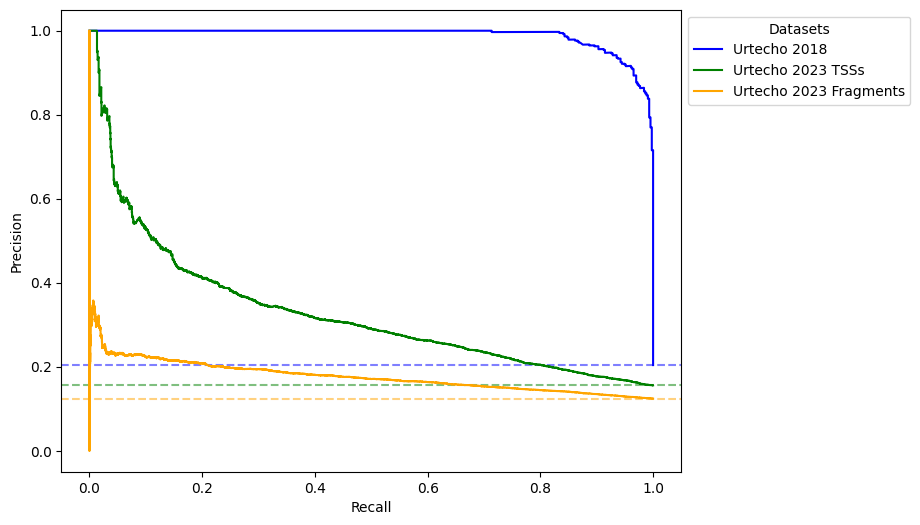

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score
from tensorflow.keras.models import load_model  # type: ignore

# -------------------- Data Preprocessing Functions --------------------

def padded_one_hot_encode(seq):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    return [mapping[n.upper()] for n in seq]

def preprocess_sequences(X, max_length=150):
    return np.array([padded_one_hot_encode(seq.zfill(max_length)) for seq in X])



model = load_model('Models/CNN_6_1_2.keras')

plt.figure(figsize=(8, 6))

# -------------------- Plot Urtecho 2018 --------------------

df = pd.read_csv('Data/LaFleur_supp.csv')
df['Observed log(TX/Txref)'] = MinMaxScaler().fit_transform(df[['Observed log(TX/Txref)']].abs())

indices = np.arange(len(df))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

df_filtered = df[df['File Name'] == 'Urtecho et al'].copy()
filtered_indices = df_filtered.index.to_numpy()
test_indices_filtered = np.intersect1d(test_indices, filtered_indices, assume_unique=True)
filtered_index_map = {idx: i for i, idx in enumerate(filtered_indices)}
test_indices_final = np.array([filtered_index_map[i] for i in test_indices_filtered])

X = preprocess_sequences(df_filtered['Promoter Sequence'].astype(str))
y = df_filtered['Observed log(TX/Txref)'].values

X_test = X[test_indices_final]
y_test = y[test_indices_final]
y_pred = model.predict(X_test)

threshold = 0.2088
y_test = y_test > threshold

precision, recall, _ = precision_recall_curve(y_test, y_pred)
avg_precision = average_precision_score(y_test, y_pred)

print(f'Urtecho 2018 AP: {avg_precision:.2f}')

plt.plot(recall, precision, label=f'Urtecho 2018', color='blue')

num_above = np.sum(y_test)
num_below = np.sum(~y_test)

random_accuracy = num_above / (num_above + num_below)

plt.axhline(y=random_accuracy, color='blue', alpha=0.5, linestyle='--', label='')

# -------------------- Plot Urtecho 2023 TSS --------------------

df = pd.read_csv('Data/Urtecho_2023_rLP5_Endo2_lb_expression_formatted_std.csv')

X_test = preprocess_sequences(df['variant'].astype(str))
y_test = df['active'].apply(lambda x: x == 'active')
y_pred = model.predict(X_test)

precision, recall, _ = precision_recall_curve(y_test, y_pred)
avg_precision = average_precision_score(y_test, y_pred)

print(f'Urtecho 2023 TSSs AP: {avg_precision:.2f}')

plt.plot(recall, precision, label=f'Urtecho 2023 TSSs', color='green')

num_above = np.sum(y_test)
num_below = np.sum(y_test == 0)

random_accuracy = num_above / (num_above + num_below)

plt.axhline(y=random_accuracy, color='green', alpha=0.5, linestyle='--', label='')

# -------------------- Plot Urtecho 2023 Fragments --------------------

df = pd.read_csv('Data/Urtecho_2023_peak_tile_expression_formatted_std.csv')

X_test = preprocess_sequences(df['variant'].astype(str))
y_test = df['active'].apply(lambda x: x == 'active')
y_pred = model.predict(X_test)

precision, recall, _ = precision_recall_curve(y_test, y_pred)
avg_precision = average_precision_score(y_test, y_pred)

print(f'Urtecho 2023 Fragments AP: {avg_precision:.2f}')

plt.plot(recall, precision, label=f'Urtecho 2023 Fragments', color='orange')

num_above = np.sum(y_test)
num_below = np.sum(~y_test)

random_accuracy = num_above / (num_above + num_below)

plt.axhline(y=random_accuracy, color='orange', alpha=0.5, linestyle='--', label='')

# -------------------- Formatting For All Plots --------------------

plt.xlabel('Recall')    
plt.ylabel('Precision')
plt.legend(title='Datasets', loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig('Figures/Figure5.pdf', dpi=300, bbox_inches='tight')
plt.show()


## Figure 6- GA optimization
___________

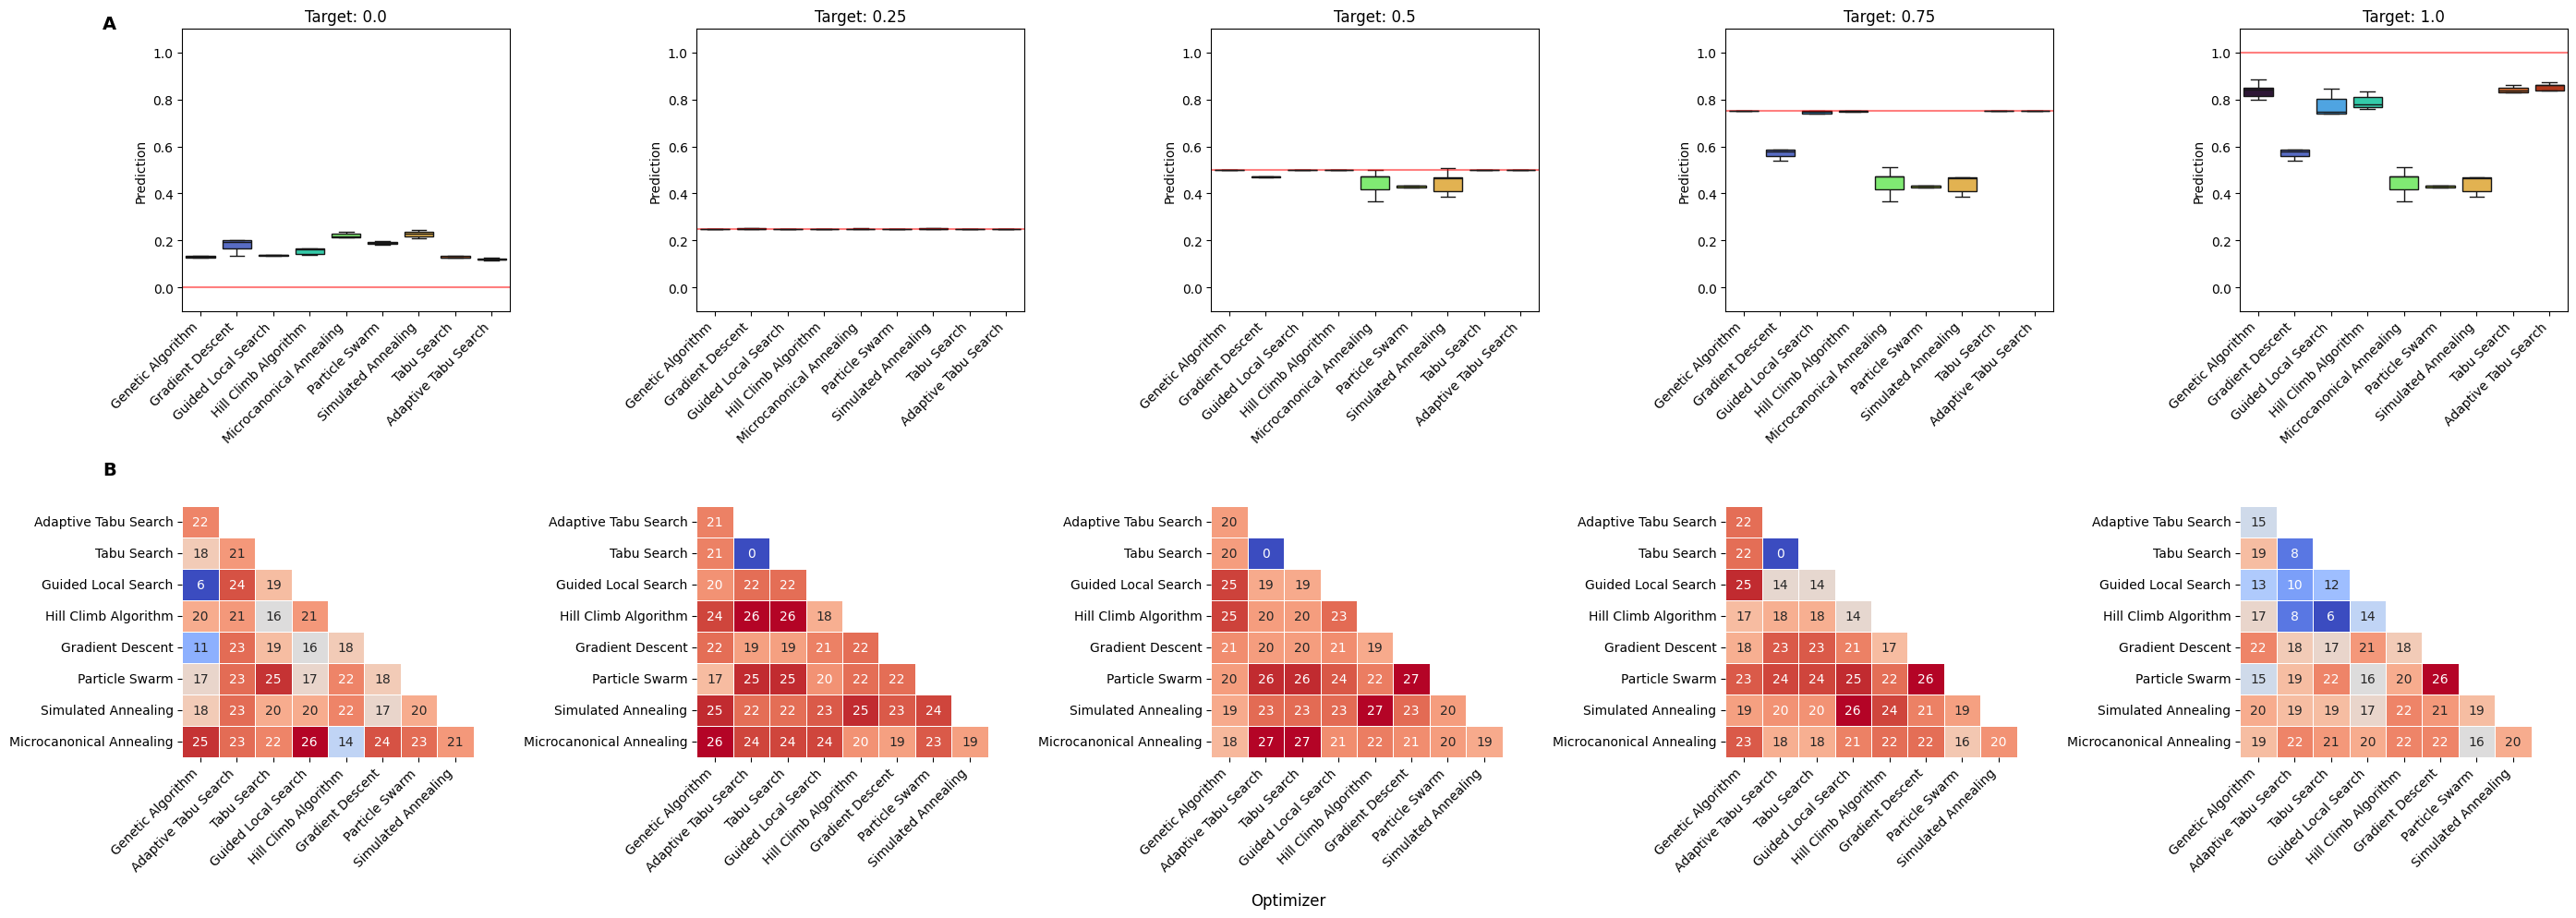

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from itertools import product

# -----------------Load & preprocess shared data-----------------
results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')
optimizer_names = results_df['optimizer'].unique()
target_expressions = results_df['target_expression'].unique()

# Colormaps and utilities
cmap = plt.get_cmap('turbo')
color_map = {desc: cmap(i / len(optimizer_names)) for i, desc in enumerate(optimizer_names)}

# -----------------Prepare Data for Figure 6B-----------------
def best_tests(df):
    grouped = df.groupby(['optimizer', 'target_expression'])
    best_rows = []
    for (optimizer, target), group in grouped:
        best_error_idx = group['error'].idxmin()
        best_row = group.loc[best_error_idx]
        best_rows.append({
            'optimizer': optimizer,
            'target_expression': target,
            'sequence': best_row['sequence'],
            'prediction': best_row['prediction'],
            'error': best_row['error'],
            'runtime': best_row['runtime'],
            'prediction_history': best_row['prediction_history'],
            'error_history': best_row['error_history'],
        })
    return pd.DataFrame(best_rows)

def hamming_distance(seq1, seq2):
    return sum(c1 != c2 for c1, c2 in zip(seq1, seq2))

# Convert string to list
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

# Extract best tests
best_df = best_tests(results_df)

# Compute sorted optimizer list for heatmap order
global_error_means = best_df.groupby('optimizer')['error'].mean()
global_sorted_optimizers = global_error_means.sort_values().index.tolist()

# Precompute Hamming distance matrices
hamming_dfs = {}
for target in target_expressions:
    target_df = best_df[best_df['target_expression'] == target]
    hamming_matrix = pd.DataFrame(index=global_sorted_optimizers, columns=global_sorted_optimizers, dtype=float)

    for opt1, opt2 in product(global_sorted_optimizers, repeat=2):
        if opt1 == opt2:
            hamming_matrix.loc[opt1, opt2] = 0
        else:
            try:
                seq1 = target_df[target_df['optimizer'] == opt1]['sequence'].values[0]
                seq2 = target_df[target_df['optimizer'] == opt2]['sequence'].values[0]
                hamming_matrix.loc[opt1, opt2] = hamming_distance(seq1, seq2)
            except IndexError:
                hamming_matrix.loc[opt1, opt2] = np.nan

    hamming_dfs[target] = hamming_matrix

# -----------------Plot Combined Figure-----------------
fig, axes = plt.subplots(2, 5, figsize=(28, 10), gridspec_kw={'height_ratios': [1, 1]})
axes = axes.reshape(2, 5)

# ---- Top Row: Boxplots ----
for i, target_expr in enumerate(target_expressions):
    ax = axes[0, i]
    sns.boxplot(
        x='optimizer',
        y='prediction',
        hue='optimizer',
        data=results_df[results_df['target_expression'] == target_expr],
        ax=ax,
        palette=color_map,
        showfliers=False
    )
    ax.set_title(f'Target: {target_expr}')
    ax.set_xlabel('')
    ax.set_ylabel('Prediction')
    ax.set_xticks(range(len(optimizer_names)))
    ax.set_xticklabels(optimizer_names, rotation=45, ha='right')

    # Horizontal line for the target value
    ax.axhline(y=target_expr, color='red', linestyle='-', alpha=0.5, label='Target Expression')

    ax.set_ylim(-0.1, 1.1)

# ---- Bottom Row: Heatmaps ----
for i, target_expr in enumerate(target_expressions):
    ax = axes[1, i]
    hamming_df = hamming_dfs[target_expr]
    mask = np.triu(np.ones_like(hamming_df, dtype=bool))

    sns.heatmap(
        hamming_df,
        mask=mask,
        cmap='coolwarm',
        annot=True,
        linewidths=0.5,
        cbar=False,
        ax=ax
    )

    # Remove the last x-tick label since it's masked
    xticks = ax.get_xticks()
    xticklabels = ax.get_xticklabels()
    ax.set_xticks(xticks[:-1])
    ax.set_xticklabels([label.get_text() for label in xticklabels[:-1]], rotation=45, ha='right')

    # Remove the first y-tick label since it's masked
    yticks = ax.get_yticks()
    yticklabels = ax.get_yticklabels()
    ax.set_yticks(yticks[1:])
    ax.set_yticklabels([label.get_text() for label in yticklabels[1:]])

# Figure text labels
axes[0, 0].text(-0.2, 1.05, "A", transform=axes[0, 0].transAxes, ha='right', va='top', fontsize=14, fontweight='bold')
axes[1, 0].text(-0.2, 1.05, "B", transform=axes[1, 0].transAxes, ha='right', va='top', fontsize=14, fontweight='bold')

# Layout adjustments
fig.supxlabel("Optimizer")
plt.tight_layout(rect=[0, 0, 1, 1])

fig.savefig('Figures/Figure6.pdf', dpi=300, bbox_inches='tight')

plt.show()

## Figure 7- Local Optima
------

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

from Generators.CNN import CNN
from itertools import product

# ---------- Functions ----------
def hamming_distance(seq1, seq2):
    return sum(c1 != c2 for c1, c2 in zip(seq1, seq2))

def generate_hybrids(A, B, up, down):
    differing_indices = [i for i in range(len(A)) if A[i] != B[i]]
    hybrids, dist_to_As, dist_to_Bs = [], [], []

    for choice in product([0, 1], repeat=len(differing_indices)):
        hybrid_chars = list(A)
        for idx, bit in zip(differing_indices, choice):
            hybrid_chars[idx] = B[idx] if bit == 1 else A[idx]

        hybrid = ''.join(hybrid_chars)
        dist_to_A = sum(1 for i in differing_indices if hybrid_chars[i] != A[i])
        dist_to_B = sum(1 for i in differing_indices if hybrid_chars[i] != B[i])

        hybrids.append(up + hybrid + down)
        dist_to_As.append(dist_to_A)
        dist_to_Bs.append(dist_to_B)

    return hybrids, dist_to_As, dist_to_Bs

def matched_nucleotides(s, target, min_shared=5):
    t_len = len(target)
    nucleotide_map = [False] * len(s)
    for i in range(len(s) - t_len + 1):
        window = s[i:i + t_len]
        match_positions = [j for j in range(t_len) if window[j] == target[j]]
        if len(match_positions) >= min_shared:
            for j in match_positions:
                nucleotide_map[i + j] = True
    return nucleotide_map

# ---------- Load Model & Data ----------
cnn = CNN('Models/CNN_6_1_2.keras')

results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')
results_df = results_df[(results_df['optimizer'] == 'Genetic Algorithm') & (results_df['target_expression'] == 1)]
results_df = results_df.sort_values(by='error')

GA_1 = results_df['sequence'].iloc[0][20:50]
GA_2 = results_df['sequence'].iloc[1][20:50]
up = 'AATACTAGAGGTCTTCCGAC'
down = 'GTGTGGGCGGGAAGACAACTAGGGG'

hybrids, dist_to_1, dist_to_2 = generate_hybrids(GA_1, GA_2, up, down)
predictions = cnn.predict(cnn.preprocess(hybrids))

grouped = {}
for dist, pred, seq in zip(dist_to_2, predictions, hybrids):
    grouped.setdefault(dist, []).append((seq, pred))

# ---------- B and C Data ----------
GA_df = pd.read_csv('Data/GA_200_sequence_analysis.csv')
bins = np.linspace(0, 1, 11)
labels = [f"{b:.1f}" for b in bins[:-1]]
GA_df['prediction_bin'] = pd.cut(GA_df['prediction'], bins=bins, labels=labels, include_lowest=True)

plot_df = pd.DataFrame()
for motif in ['35', '10']:
    for kind in ['consensus', 'near_consensus']:
        temp_df = GA_df[['prediction_bin']].copy()
        temp_df['count'] = GA_df[f'{kind}_h{motif}_count']
        temp_df['Type'] = f"{'Consensus' if kind == 'consensus' else 'Near Consensus'} -{motif}"
        plot_df = pd.concat([plot_df, temp_df])

color_map = {
    'Consensus -35': 'orange',
    'Near Consensus -35': 'bisque',
    'Consensus -10': 'royalblue',
    'Near Consensus -10': 'lightsteelblue',
}

# ---------- Combined Plot ----------
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[3, 2])
axA = fig.add_subplot(gs[0, :])
axB = fig.add_subplot(gs[1, 0])
axC = fig.add_subplot(gs[1, 1], sharey=axB)

# --- Figure A ---
sorted_dists = sorted(grouped.keys())
for i in range(len(sorted_dists) - 1):
    d1, d2 = sorted_dists[i], sorted_dists[i + 1]
    for seq1, pred1 in grouped[d1]:
        for seq2, pred2 in grouped[d2]:
            if hamming_distance(seq1, seq2) == 1:
                axA.plot([d1, d2], [pred1, pred2], color='grey', alpha=0.3, linewidth=0.8)

for dist, items in grouped.items():
    items.sort(key=lambda x: x[0])
    x_vals = [dist] * len(items)
    y_vals = [pred for _, pred in items]
    axA.scatter(x_vals, y_vals, color='black', alpha=0.6, zorder=3)

h35, h10 = 'TTGACA', 'TATAAT'
fontsize = 8
char_width = 0.13
underline_offset = 0.001
underline_length = 0.07

h35_match_GA1 = matched_nucleotides(GA_1, h35)
h10_match_GA1 = matched_nucleotides(GA_1, h10)
h35_match_GA2 = matched_nucleotides(GA_2, h35)
h10_match_GA2 = matched_nucleotides(GA_2, h10)

x0, y0 = 0, 0.8625
for i, (c1, c2) in enumerate(zip(GA_1, GA_2)):
    if h35_match_GA2[i]: color = 'orange'
    elif h10_match_GA2[i]: color = 'royalblue'
    elif c1 == c2: color = 'black'
    else: color = 'black'
    x_char = x0 + i * char_width
    axA.text(x_char, y0, c2, fontsize=fontsize, ha='center', color=color)
    if c1 != c2:
        axA.plot([x_char - underline_length/2, x_char + underline_length/2], [y0 - underline_offset]*2, color='black', linewidth=0.5)

x1, y1 = 11, 0.7
for i, (c1, c2) in enumerate(zip(GA_1, GA_2)):
    if h35_match_GA1[i]: color = 'orange'
    elif h10_match_GA1[i]: color = 'royalblue'
    elif c1 == c2: color = 'black'
    else: color = 'black'
    x_char = x1 - (len(GA_2) - i - 1) * char_width
    axA.text(x_char, y1, c1, fontsize=fontsize, ha='center', color=color)
    if c1 != c2:
        axA.plot([x_char - underline_length/2, x_char + underline_length/2], [y1 - underline_offset]*2, color='black', linewidth=0.5)

axA.set_xticks(range(min(sorted_dists), max(sorted_dists)+1))
axA.set_xlabel('Number of Nucleotide Substitutions')
axA.set_ylabel('Predicted Expression')
axA.text(-0.025, 1.05, 'A', transform=axA.transAxes, fontsize=14, fontweight='bold')

# --- Figure B & C ---
for i, (ax, motif) in enumerate(zip([axB, axC], ['35', '10'])):
    subset = plot_df[plot_df['Type'].str.contains(f'-{motif}')]
    sns.boxplot(
        data=subset, x='prediction_bin', y='count', hue='Type',
        palette={k: v for k, v in color_map.items() if f'-{motif}' in k},
        ax=ax
    )
    ax.legend(loc='upper left')
    ax.set_xlabel('Target Expression')
    if ax is axC:
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.set_ylabel("")
    else:
        ax.set_ylabel('Number of Occurrences')
    ax.text(-0.05, 1.05, 'B' if motif == '35' else 'C', transform=ax.transAxes, fontsize=14, fontweight='bold')

plt.tight_layout()
fig.savefig('Figures/Figure7.pdf', dpi=300, bbox_inches='tight')
plt.show()



## Figure 8- Validation of known and GA-generated promoters

2025-05-21 14:00:34.728186: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


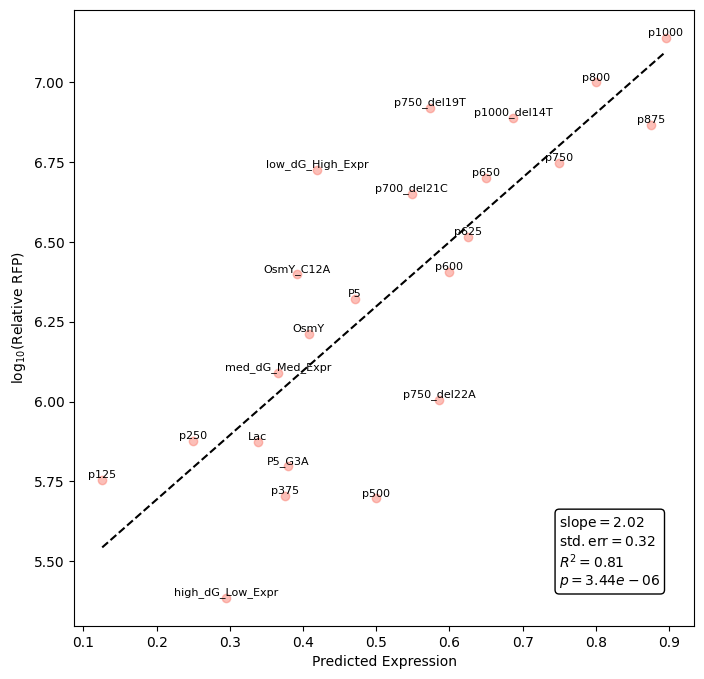

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras


#  ----------------- Preprocessing Functions -----------------

def pad(sequence):
    sequence = sequence.replace('_', '')
    desired_length = 150
    
    # add sepcial padding for GFP (not inserted in the plasmid)
    if sequence == 'CGATGGTGTCAACGTAAATGCATGCCGCTGGTCTCT':
        upstream = 'TATCATGCCATACCGCGAAAGGTTTTGCACCATT'
    else:
        upstream = 'AATACTAGAGGTCTTCCGAC'

    downstream = 'GCGGGAAGACAACTAGGGG'
    sequence = upstream + sequence + downstream
    return sequence.zfill(desired_length)

def padded_one_hot_encode(sequence):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    encoding = [mapping[nucleotide.upper()] for nucleotide in sequence]
    return encoding

# ------------- Load the RPF Data -------------

df = pd.read_table('Data/RFP/Observed_RFP_GFP.txt')
seq_map = pd.read_table('Data/RFP/Sequences.txt')

df.loc[:, 'Ec'] = df['Ec'].astype(int)
seq_map.loc[:, 'Ec'] = seq_map['Ec'].astype(int)
df = df.merge(seq_map, on='Ec', how='left')

# load the model
model = keras.saving.load_model('Models/CNN_6_1_2.keras')

# preprocess the sequences
sequences = df['sequence'].apply(lambda x: x.replace('_', '')).tolist()
padded_sequences = [pad(seq) for seq in sequences]
encoded_sequences = np.array([padded_one_hot_encode(seq) for seq in padded_sequences])

# predict the RFP values
df['Pred_RFP'] = model.predict(encoded_sequences, batch_size=32, verbose=1)

# ----------------- Plot Predicted vs Observed RFP -----------------

from scipy.stats import linregress

df_filtered = df.copy()
df_filtered = df_filtered[df_filtered['Description'] != 'pClone_GFP']
df_filtered['log_RFP'] = np.log10(df_filtered['Rel_RFP'])

x_vals = []
y_vals = []

plt.figure(figsize=(8, 8))
for idx, row in df_filtered.iterrows():
    name = row['Description']

    x = row['Pred_RFP']
    y = row['log_RFP']

    x_vals.append(x)
    y_vals.append(y)

    plt.scatter(x, y, color='salmon', label=name, alpha=0.5)
    plt.text(x, y, name, fontsize=8, ha='center', va='bottom')

slope, intercept, r_value, p_value, std_err = linregress(x_vals, y_vals)

x_range = np.linspace(min(x_vals), max(x_vals), 100)
y_pred = slope * x_range + intercept
plt.plot(x_range, y_pred, color='black', linestyle='--', label='Linear Fit')

plt.xlabel('Predicted Expression')
plt.ylabel('log$_{10}$(Relative RFP)')

textstr = '\n'.join((
        r'$\mathrm{slope}=%.2f$' % slope,
        r'$\mathrm{std.err}=%.2f$' % std_err,
        r'$R^2=%.2f$' % r_value,
        r'$p=%.2e$' % p_value
    ))

props = dict(boxstyle='round', facecolor='white')
plt.text(0.8, 5.65, textstr, fontsize=10, verticalalignment='top', bbox=props)
fig.savefig('Figures/Figure8.pdf', dpi=300, bbox_inches='tight')

plt.show()


## Table1- Summary of datasets for CNN model training


In [101]:
import pandas as pd

df = pd.read_csv('Data/CNN_file_metrics.csv')[['File Name','Sequence Count','Within-File Entropy', 'Within-File Hamming Distance', 
											   'Training Data MSE Averages', 'Training Data CV',
											   'All Data MSE Averages', 'All Data CV', ]]
df.rename(columns={'File Name' : 'Dataset', 'Sequence Count': 'Dataset Size',
				   'Training Data MSE Averages': ' Average Mean Square Error-MSE (Self)',
				   'Training Data CV': 'Relative Standard Deviation of MSE- RSD (Self)',
				   'All Data MSE Averages': 'Average MSE (Aggregated)',
				   'All Data CV': 'RSD of MSE (Aggregated)'}, inplace=True)

df.to_csv('Figures/Table1.csv', index=False)
df.head(None)

,Dataset,Dataset Size,Within-File Entropy,Within-File Hamming Distance,Average Mean Square Error-MSE (Self),Relative Standard Deviation of MSE- RSD (Self),Average MSE (Aggregated),RSD of MSE (Aggregated)
0,La Fleur et al,5391,0.732649,25.358800,0.000894,0.072744,0.095725,0.227085
1,Urtecho et al,10898,1.513936,87.552700,0.000367,0.164779,0.033381,0.172279
2,Yu et al,1493,0.352242,22.132300,0.001616,0.258020,0.332792,0.167959
3,Lagator et al Pr,12194,0.375852,16.150200,0.001881,0.039902,0.072140,0.196077
4,Lagator et al 36N,11485,0.614703,26.732600,0.002698,0.026652,0.117030,0.108187
5,Lagator et al Pl,2903,0.419147,16.137700,0.004019,0.122361,0.163745,0.137066
6,Hossain et al,4350,1.799955,52.433700,0.008455,0.053693,0.154847,0.170077
7,Anderson et al,18,0.205827,3.481481,0.012016,0.290574,0.416816,0.280333
8,De Novo Designs,35,1.217053,59.812245,0.015945,0.349975,0.032932,0.131731


# Supplementary Figures

## Figure S1 - Dataset size versus Average MSE and Variations in MSE with Sequence Diversity
-----

/var/folders/c5/00kj5vrd7qd3b5q3c79llp540000gn/T/ipykernel_73624/437337079.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


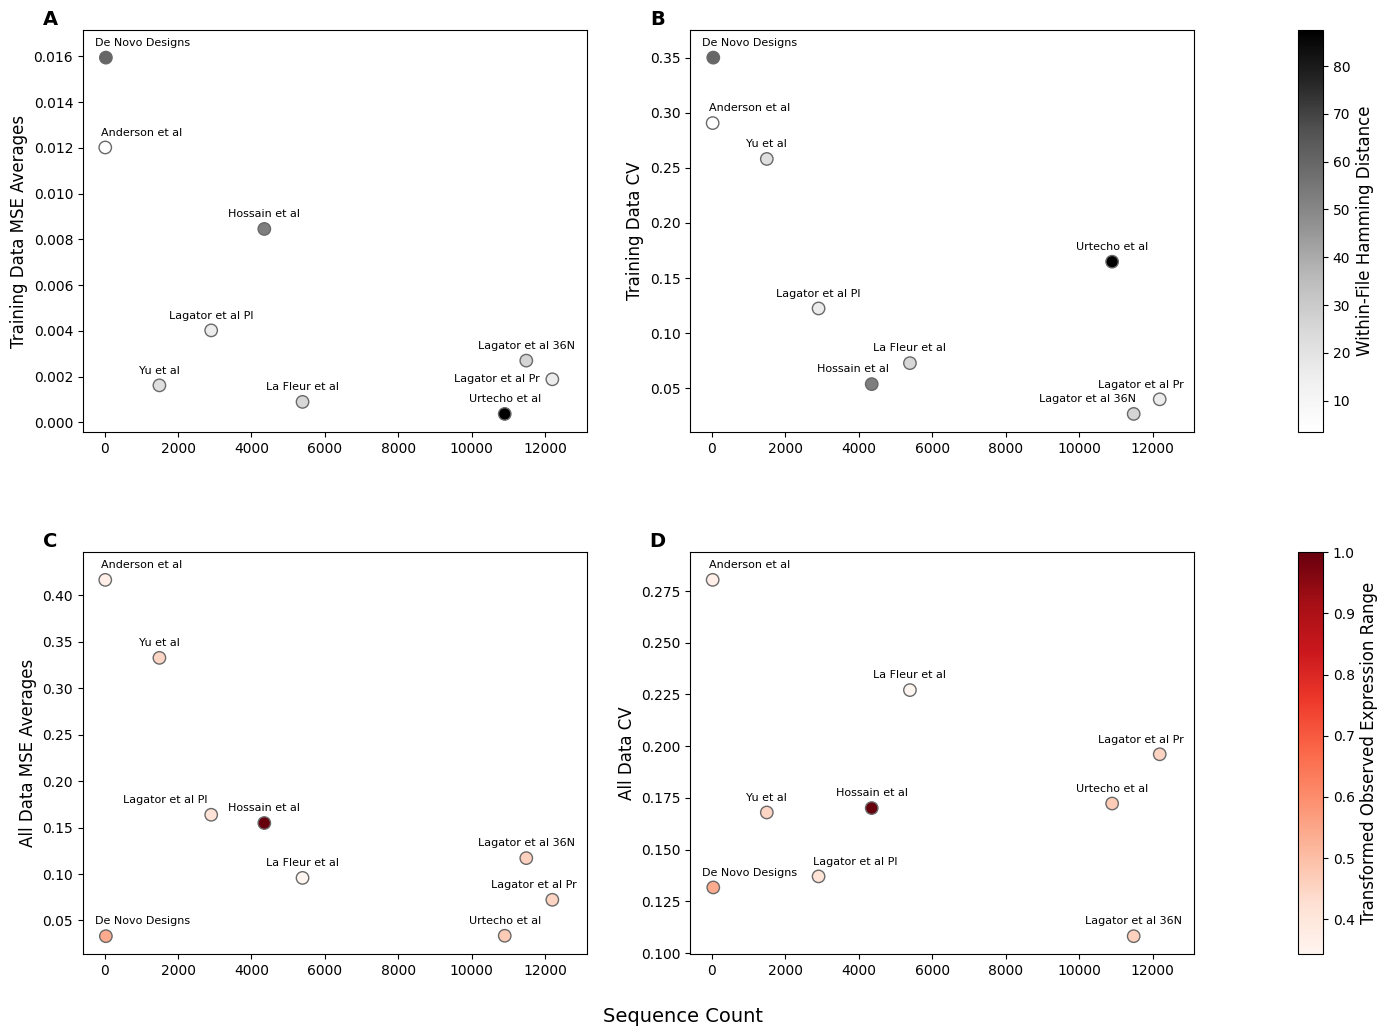

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm, colors as mcolors
from sklearn.preprocessing import MinMaxScaler

# -------------------------- Helper Functions --------------------------

def adjust_text_pos_train(idx, x, y, y_offset, label):
    custom_offsets = {
        ('De Novo Designs', None): (1000, 0),
        ('Anderson et al', None): (1000, 0),
        ('Lagator et al Pr', 0): (-1500, -y_offset * 1.5),
        ('Lagator et al Pr', 1): (-500, 0),
        ('Hossain et al', 1): (-500, 0),
        ('Lagator et al 36N', 1): (-1250, 0),
    }
    dx, dy = custom_offsets.get((label, idx)) or custom_offsets.get((label, None), (0, 0))
    return x + dx, y + dy

def adjust_text_pos_test(idx, x, y, y_offset, label):
    custom_offsets = {
        ('De Novo Designs', None): (1000, 0),
        ('Anderson et al', None): (1000, 0),
        ('Lagator et al Pl', 0): (-1250, 0),
        ('Lagator et al Pl', 1): (1000, 0),
        ('Lagator et al Pr', None): (-500, 0),
    }
    dx, dy = custom_offsets.get((label, idx)) or custom_offsets.get((label, None), (0, 0))
    return x + dx, y + dy

# -------------------------- Load & Preprocess Data --------------------------

df = pd.read_csv('Data/CNN_file_metrics.csv')
df_LaFleur = pd.read_csv('Data/LaFleur_supp.csv')
df_LaFleur['Min-Max Observed'] = MinMaxScaler().fit_transform(
    df_LaFleur[['Observed log(TX/Txref)']].abs()
)
observed_range = (
    df_LaFleur.groupby('File Name')['Min-Max Observed']
    .agg(lambda x: x.max() - x.min())
    .reset_index()
    .rename(columns={'Min-Max Observed': 'Observed Range'})
)
df = df.merge(observed_range, on='File Name', how='left')

# -------------------------- Setup Figure --------------------------

fig = plt.figure(figsize=(16, 12))
gs = GridSpec(2, 3, width_ratios=[1, 1, 0.05], wspace=0.3, hspace=0.3)
axes = [fig.add_subplot(gs[i // 2, i % 2]) for i in range(4)]

# -------------------------- Plot Train --------------------------

train_y_cols = ['Training Data MSE Averages', 'Training Data CV']
train_color_col = 'Within-File Hamming Distance'
train_norm = mcolors.Normalize(vmin=df[train_color_col].min(), vmax=df[train_color_col].max())
cmap = cm.Greys
x_col = 'Sequence Count'

for idx, (ax, y_col) in enumerate(zip(axes[:2], train_y_cols)):
    scatter = ax.scatter(
        df[x_col],
        df[y_col],
        c=df[train_color_col],
        cmap=cmap,
        edgecolor='dimgrey',
        s=80
    )
    x_offset = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.025
    y_offset = (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.025
    for _, row in df.iterrows():
        x, y = row[x_col], row[y_col] + y_offset
        label = row['File Name']
        adj_x, adj_y = adjust_text_pos_train(idx, x, y, y_offset, label)
        ax.text(adj_x, adj_y, label, fontsize=8, ha='center', va='bottom')
    ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1] + x_offset)
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] + y_offset)
    ax.set_ylabel(y_col, fontsize=12)
    ax.text(-0.05, 1.05, chr(65 + idx), transform=ax.transAxes, ha='right', va='top', fontsize=14, fontweight='bold')

cbar_ax_train = fig.add_subplot(gs[0, 2])
fig.colorbar(cm.ScalarMappable(norm=train_norm, cmap=cmap), cax=cbar_ax_train).set_label(train_color_col, fontsize=12)

# -------------------------- Plot Test --------------------------

test_y_cols = ['All Data MSE Averages', 'All Data CV']
test_color_col = 'Observed Range'
test_norm = mcolors.Normalize(vmin=df[test_color_col].min(), vmax=df[test_color_col].max())

cmap = cm.Reds

for idx, (ax, y_col) in enumerate(zip(axes[2:], test_y_cols)):
    scatter = ax.scatter(
        df[x_col],
        df[y_col],
        c=df[test_color_col],
        cmap=cmap,
        edgecolor='dimgrey',
        s=80
    )
    x_offset = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.025
    y_offset = (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.025
    for _, row in df.iterrows():
        x, y = row[x_col], row[y_col] + y_offset
        label = row['File Name']
        adj_x, adj_y = adjust_text_pos_test(idx, x, y, y_offset, label)
        ax.text(adj_x, adj_y, label, fontsize=8, ha='center', va='bottom')
    ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1] + x_offset)
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] + y_offset)
    ax.set_ylabel(y_col, fontsize=12)
    ax.text(-0.05, 1.05, chr(67 + idx), transform=ax.transAxes, ha='right', va='top', fontsize=14, fontweight='bold')

cbar_ax_test = fig.add_subplot(gs[1, 2])
fig.colorbar(cm.ScalarMappable(norm=test_norm, cmap=cmap), cax=cbar_ax_test).set_label('Transformed Observed Expression Range', fontsize=12)

fig.supxlabel(x_col, fontsize=14, y=0.05)
plt.tight_layout()
fig.savefig('Figures/FigureS1.pdf', dpi=300, bbox_inches='tight')
plt.show()



## Figure S1 E- Transformed Expression distributions for each dataset

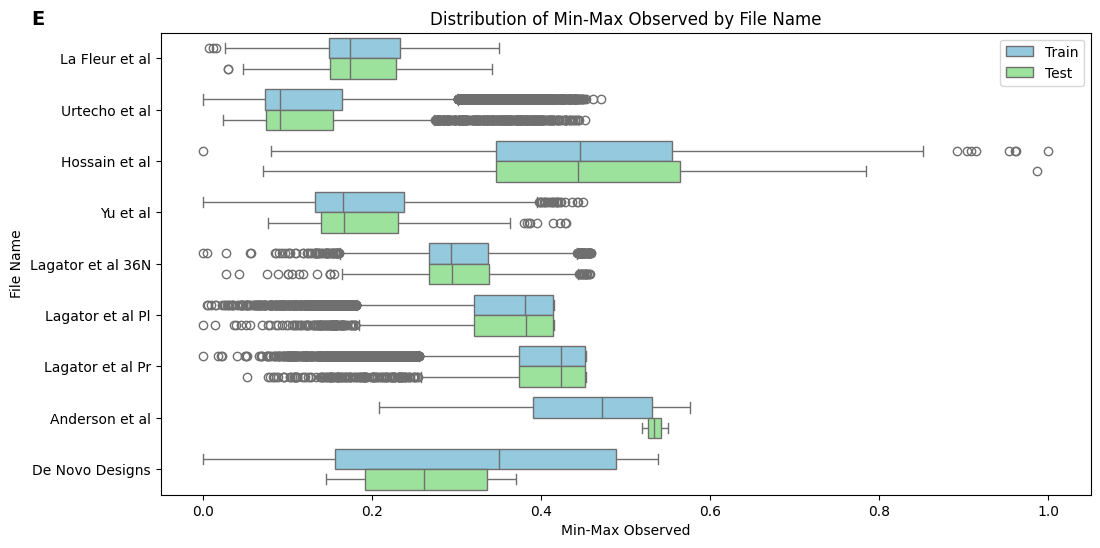

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load and process data
df = pd.read_csv('Data/LaFleur_supp.csv')
df['Min-Max Observed'] = MinMaxScaler().fit_transform(df[['Observed log(TX/Txref)']].abs())

# Split into train/test
indices = np.arange(len(df))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)
df['Split'] = 'Train'
df.loc[test_idx, 'Split'] = 'Test'

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Min-Max Observed', y='File Name', hue='Split', palette={'Train': 'skyblue', 'Test': 'lightgreen'})

plt.title('Distribution of Min-Max Observed by File Name')
plt.xlabel('Min-Max Observed')
plt.ylabel('File Name')
plt.legend()

plt.text(-0.125, 1.05, 'E', transform=plt.gca().transAxes,
         ha='right', va='top', fontsize=14, fontweight='bold')

# Save figure
plt.savefig('Figures/FigureS1E.pdf', dpi=300, bbox_inches='tight')
plt.show()


## Figure S2 - Pairwise sequence diversity between datasets
-----

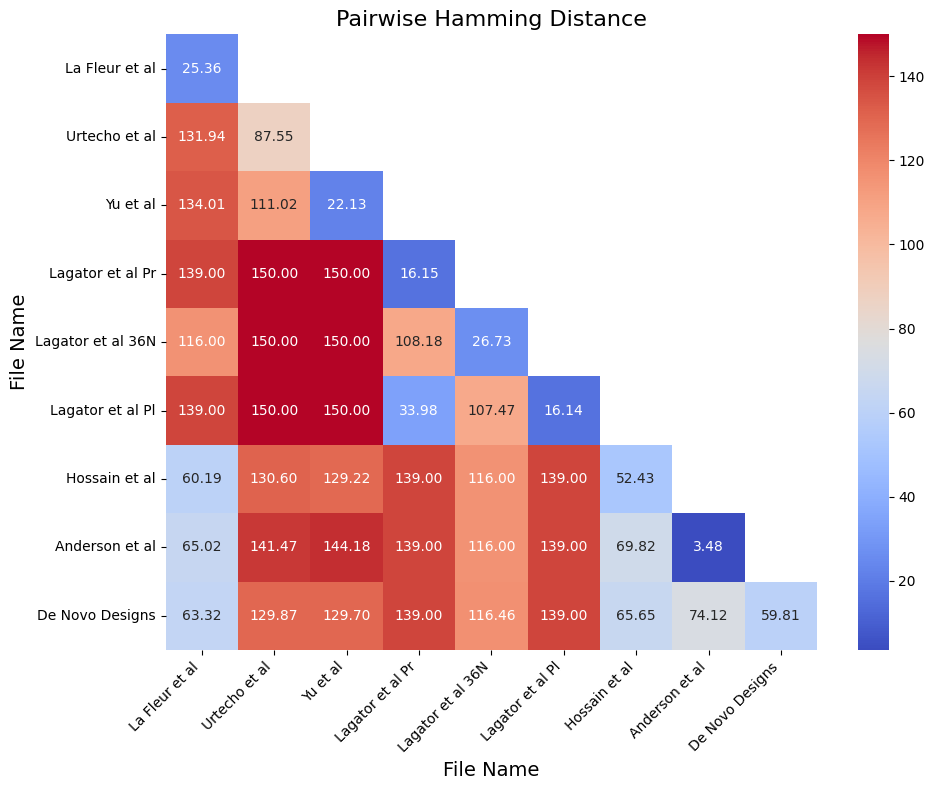

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pairwise_distances = pd.read_csv('Data/pairwise_file_distance.csv', index_col=0)
mask = np.triu(np.ones(pairwise_distances.shape), k=1)

plt.figure(figsize=(10, 8))
sns.heatmap(pairwise_distances, 
            cmap='coolwarm', 
            annot=True, 
            fmt=".2f", 
            mask=mask, 
            xticklabels=pairwise_distances.columns, 
            yticklabels=pairwise_distances.index)

plt.title('Pairwise Hamming Distance', fontsize=16)
plt.xlabel('File Name', fontsize=14)
plt.ylabel('File Name', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save the figure
plt.savefig('Figures/FigureS2.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Figure S3- Figure 2 for all datasets
-----

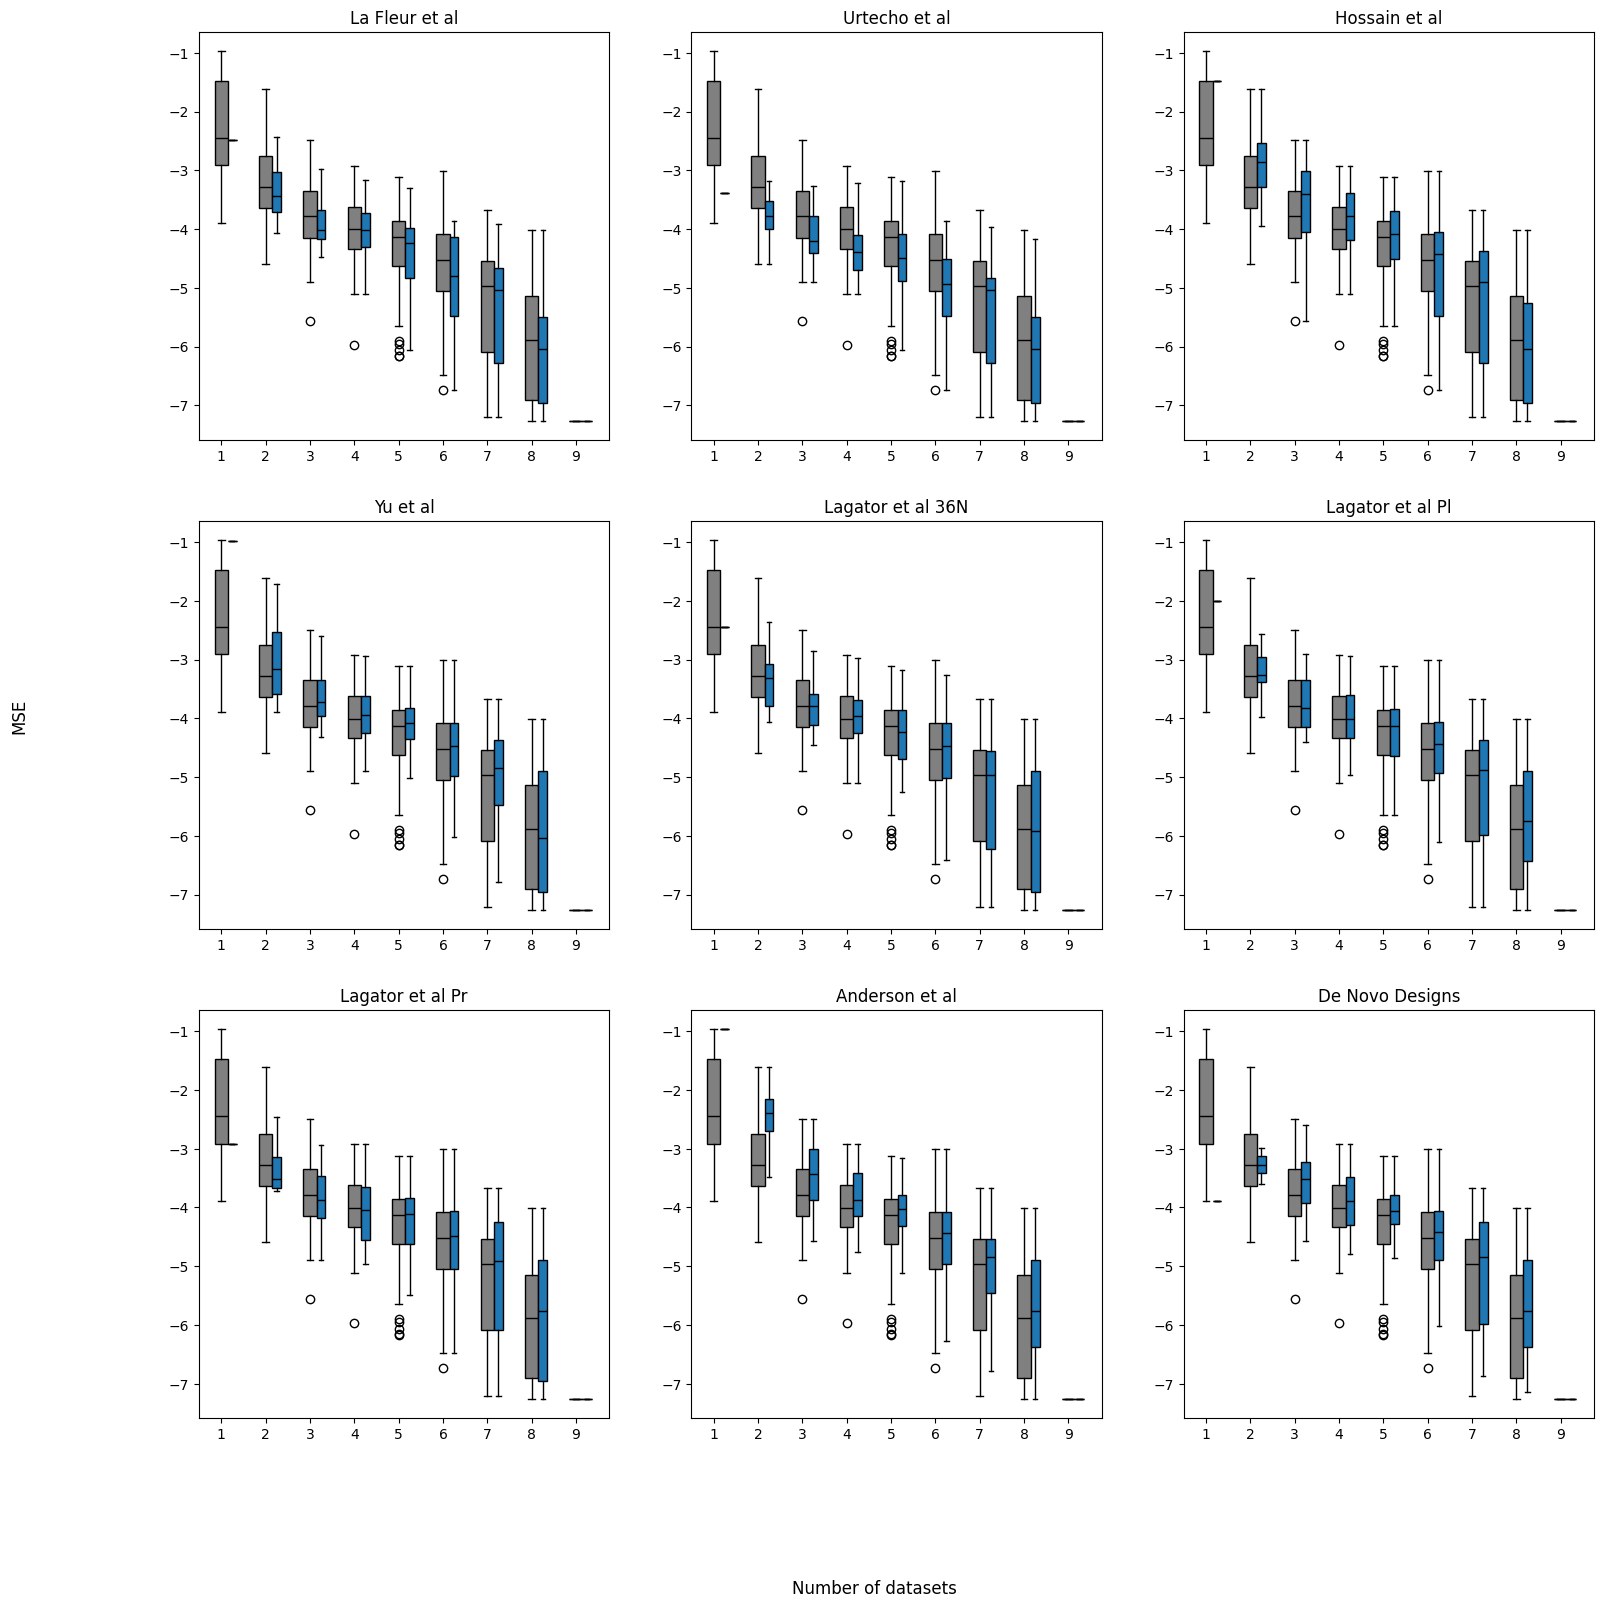

In [105]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
file_names = pd.read_csv('Data/LaFleur_supp.csv')['File Name'].unique()

data_df = pd.read_csv('Data/data_comparison.csv')
data = data_df[['Number of Files', 'MSE', 'Name']].values

x_all = sorted(set(int(n) for n, _, _ in data))

fig, axs = plt.subplots(3, 3, figsize=(18, 18))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i, file_name in enumerate(file_names):
    row, col = divmod(i, 3)
    ax = axs[row, col]
    
    ax.set_title(file_name)
    for x in x_all:
        y_vals = [l for n, l, combo in data if int(n) == x]
        ax.boxplot([y_vals], positions=[x], widths=0.3, patch_artist=True,
                    boxprops=dict(facecolor='grey'),
                    medianprops=dict(color='black'))
        y_vals = [mse for n, mse, combo in data if int(n) == x and file_name in str(combo)]
        
        # Offset x slightly for visual separation
        offset = 0.25
        ax.boxplot([y_vals], positions=[x + offset], 
                   widths=0.2, patch_artist=True, showfliers=False,
                   medianprops=dict(color='black'))
    ax.set_xticks(x_all, labels=[str(i) for i in x_all])
fig.supxlabel("Number of datasets")
fig.supylabel("MSE")

fig.savefig('Figures/FigureS3.pdf', dpi=300, bbox_inches='tight')


### Figure S4
----

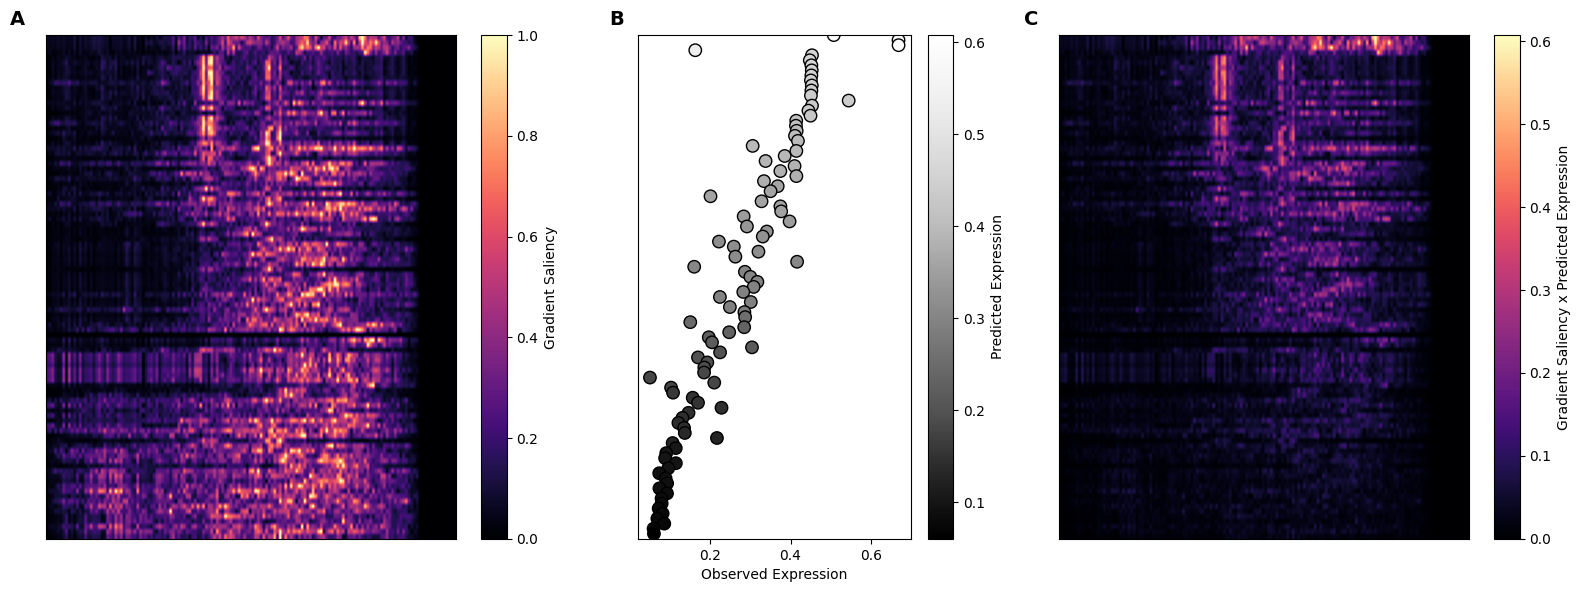

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import tensorflow as tf
from tensorflow.keras.models import load_model  # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# -------------------- Data Preprocessing Functions --------------------

def combine_columns(df):
    X = df['Promoter Sequence'].astype(str)
    y = MinMaxScaler().fit_transform(df[['Observed log(TX/Txref)']].abs())
    return X, y

def padded_one_hot_encode(seq):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    return [mapping[n.upper()] for n in seq]

def preprocess_sequences(X, max_length=150):
    return np.array([padded_one_hot_encode(seq.zfill(max_length)) for seq in X])

# ----------------------- Generate Saliency Maps -----------------------

def generate_saliency_map(model, sequence):
    input_tensor = tf.convert_to_tensor(sequence[np.newaxis, ...], dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        prediction = model(input_tensor)[0, 0]
    gradient = tape.gradient(prediction, input_tensor)
    gradient = tf.norm(gradient, axis=-1)
    return (gradient / tf.reduce_max(gradient)).numpy()

# -------------------- Main Execution --------------------

# load data and preprocess
df = pd.read_csv('Data/LaFleur_supp.csv')
X, y = combine_columns(df)
X = preprocess_sequences(X)
_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Variables for plotting
model_filename='Models/CNN_6_1_2.keras'
data=X_test
y_vals=y_test
num_samples=100
random_state=1

model = load_model(model_filename)

# ----------------------- Generate Saliency Maps -----------------------

# randomly select "num_samples" sequences from the data
np.random.seed(random_state)
indices = np.random.choice(len(data), size=min(num_samples, len(data)), replace=False)
sequences = data[indices]
y_subset = y_vals[indices]

predictions = []
saliency_maps = []
relative_saliency_maps = []

for seq in sequences:
    pred = model(tf.convert_to_tensor(seq[np.newaxis, ...], dtype=tf.float32))[0, 0].numpy()
    saliency = np.abs(generate_saliency_map(model, seq))
    saliency = np.nan_to_num(saliency)
    
    predictions.append(pred)
    saliency_maps.append(saliency)
    relative_saliency_maps.append(pred * saliency)

# Sort by predictions
sort_idx = np.argsort(predictions)[::-1]
predictions = [predictions[i] for i in sort_idx]
saliency_maps = [saliency_maps[i] for i in sort_idx]
relative_saliency_maps = [relative_saliency_maps[i] for i in sort_idx]
y_subset = [y_subset[i] for i in sort_idx]

saliency_matrix = np.vstack(saliency_maps)
relative_saliency_matrix = np.vstack(relative_saliency_maps)

# ------------------------- Plot Saliency Maps -------------------------

fig = plt.figure(figsize=(16, 6))
# gs = gridspec.GridSpec(1, 3, width_ratios=[2, 1, 2])
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 2, 3])

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[2])

# Left plot: saliency map
im = ax0.imshow(
    saliency_matrix,
    cmap='magma',
    aspect='auto',
    vmin=saliency_matrix.min(),
    vmax=saliency_matrix.max()
)
ax0.set_xticks([])
ax0.set_yticks([])

fig.colorbar(im, ax=ax0, label='Gradient Saliency')

ax0.text(-0.05, 1.05, "A", transform=ax0.transAxes, ha='right', va='top', fontsize=14, fontweight='bold')

# Middle plot: scatter
# ax1.scatter(y_subset, range(len(y_subset)), cmap='Greys', c=predictions, s=80, edgecolor='black')
ax1.scatter(y_subset, range(len(y_subset)), cmap='Greys_r', c=predictions, s=80, edgecolor='black')
ax1.invert_yaxis()
ax1.set_xlabel("Observed Expression")
ax1.set_ylim(len(y_subset), 0)
ax1.set_yticks([])

# add color bar
cbar = plt.colorbar(ax1.collections[0], ax=ax1, label='Predicted Expression')

ax1.text(-0.05, 1.05, "B", transform=ax1.transAxes, ha='right', va='top', fontsize=14, fontweight='bold')

# Right plot: saliency map
im = ax2.imshow(
    relative_saliency_matrix,
    cmap='magma',
    aspect='auto',
    vmin=relative_saliency_matrix.min(),
    vmax=relative_saliency_matrix.max()
)
ax2.set_xticks([])
ax2.set_yticks([])

fig.colorbar(im, ax=ax2, label='Gradient Saliency x Predicted Expression')

ax2.text(-0.05, 1.05, "C", transform=ax2.transAxes, ha='right', va='top', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('Figures/FigureS4.pdf', dpi=300, bbox_inches='tight')
plt.show()


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


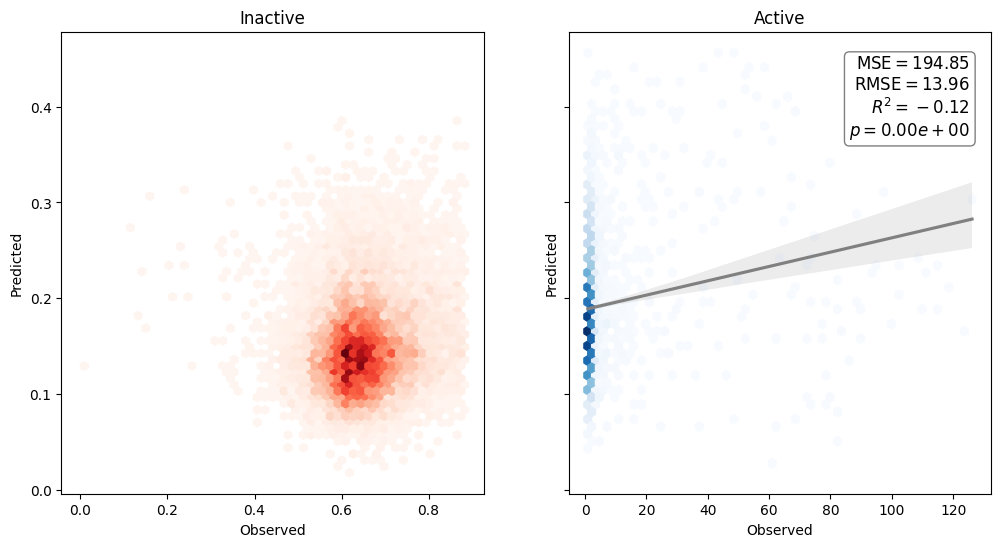

In [107]:
# Scatter plot for active/inactive promoter predictions sourced from fragments

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.saving import load_model  # type: ignore
import seaborn as sns
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

# -------------------- Data Preprocessing Functions --------------------

def preprocess_sequences(X, max_length=150):
    return np.array([padded_one_hot_encode(seq.zfill(max_length)) for seq in X])

def padded_one_hot_encode(sequence):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1], '0': [0, 0, 0, 0]}
    return np.array([mapping[nucleotide.upper()] for nucleotide in sequence])

model = load_model('Models/CNN_6_1_2.keras')

df = pd.read_csv('Data/Urtecho_2023_rLP5_Endo2_lb_expression_formatted_std.csv')

df_active = df[df['active'] == 'active'].copy()
df_inactive = df[df['active'] == 'inactive'].copy()

# Group the data by condition
X_test_active = df_active['variant']
y_test_active = df_active['expn_med_fitted']

X_test_inactive = df_inactive['variant']
y_test_inactive = df_inactive['expn_med_fitted']

y_pred_active = model.predict(preprocess_sequences(X_test_active)).flatten()
y_pred_inactive = model.predict(preprocess_sequences(X_test_inactive)).flatten()

# make a scatter plot between y_test_active and y_pred
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

axes[0].hexbin(y_test_inactive, y_pred_inactive, gridsize=50, cmap='Reds', mincnt=1)
axes[0].set_title('Inactive')
axes[0].set_xlabel('Observed')
axes[0].set_ylabel('Predicted')

model = LinearRegression()
model.fit(np.array(y_test_active).reshape(-1, 1), y_pred_active)
lin_y_pred_active = model.predict(np.array(y_test_active).reshape(-1, 1))

mse_active = mean_squared_error(y_test_active, lin_y_pred_active)
rmse_active = root_mean_squared_error(y_test_active, lin_y_pred_active)
r2_active = r2_score(y_test_active, lin_y_pred_active)
corr_coef, p_value = pearsonr(y_test_active, lin_y_pred_active)


# get linear regression line from min to max of y_test_active
x = np.array([y_test_active.min(), y_test_active.max()]).reshape(-1, 1)
y = model.predict(x)

axes[1].hexbin(y_test_active, y_pred_active, gridsize=50, cmap='Blues', mincnt=1)
sns.regplot(
    x=y_test_active,
    y=y_pred_active,
    scatter=False,
    color='grey',
    fit_reg=True,
)
axes[1].set_title('Active')
axes[1].set_xlabel('Observed')
axes[1].set_ylabel('Predicted')


textstr = '\n'.join((
    r'$\mathrm{MSE}=%.2f$' % mse_active,
    r'$\mathrm{RMSE}=%.2f$' % rmse_active,
    r'$R^2=%.2f$' % r2_active,
    r'$p=%.2e$' % p_value
))

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

axes[1].text(0.95, 0.95, textstr, transform=axes[1].transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right', bbox=props)
plt.savefig('Figures/FigureS5.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Figure S6- Time of approaches for Generators

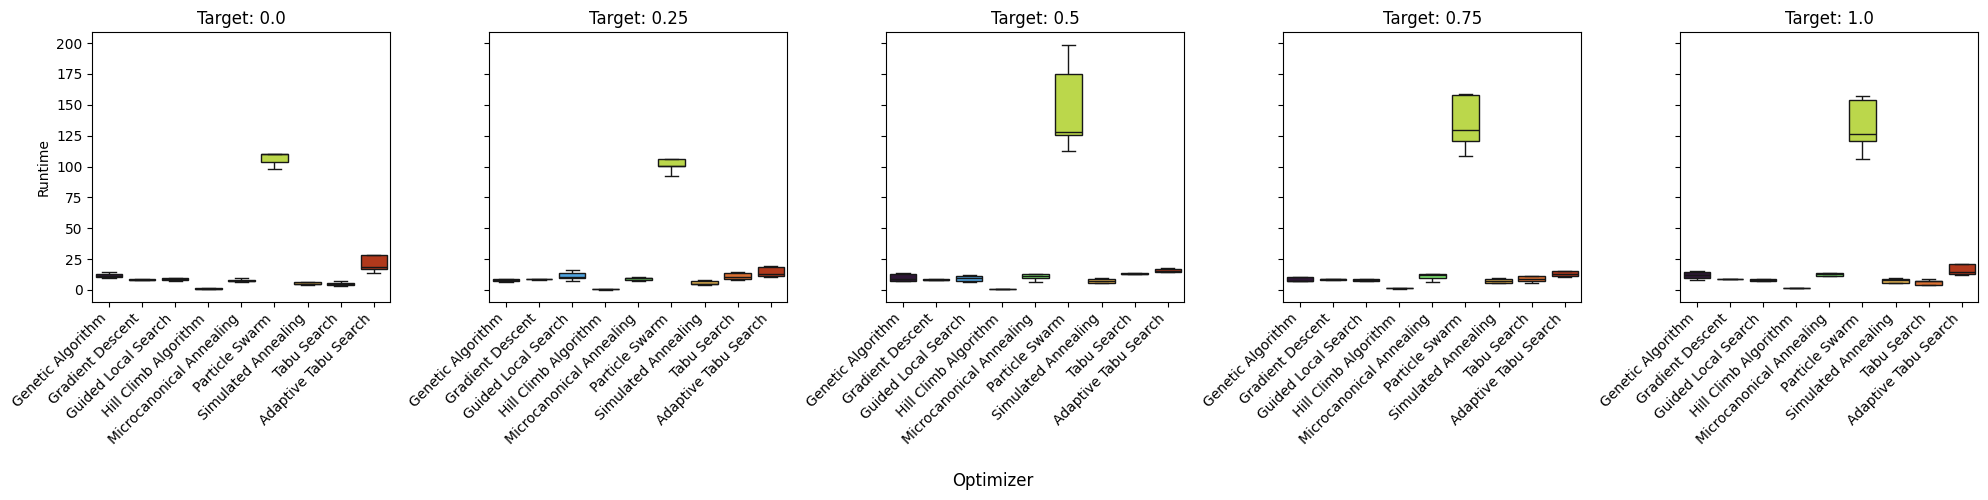

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

'''-----------------Figure S6-----------------'''

# Load data
results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')

cmap = plt.get_cmap('turbo')
optimizer_names = results_df['optimizer'].unique()
color_map = {desc: cmap(i / len(optimizer_names)) for i, desc in enumerate(optimizer_names)}

target_expressions = results_df['target_expression'].unique()
num_targets = len(target_expressions)

# Grid layout
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)
axes = axes.flatten()

optimizer_names = results_df['optimizer'].unique()

# Plot each target expression
for i, target_expr in enumerate(target_expressions):
    sns.boxplot(
        x='optimizer',
        y='runtime',
        hue='optimizer',
        data=results_df[results_df['target_expression'] == target_expr],
        ax=axes[i],
        palette=color_map,
        showfliers=False
    )
    axes[i].set_title(f'Target: {target_expr}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Runtime')
    axes[i].set_xticks(range(len(optimizer_names)))
    axes[i].set_xticklabels(optimizer_names, rotation=45, ha='right')

fig.supxlabel("Optimizer")

plt.tight_layout(rect=[0, 0, 1, 1])

# Save the figure
plt.savefig('Figures/FigureS6.pdf', dpi=300, bbox_inches='tight')

plt.show()

### TableS1- Thomason linear regression
-----

In [109]:
# Thomasan et al data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.saving import load_model  # type: ignore
import seaborn as sns
from sklearn.preprocessing import QuantileTransformer
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# -------------------- Data Preprocessing Functions --------------------

def preprocess_sequences(X, max_length=150):
    return np.array([padded_one_hot_encode(seq.zfill(max_length)) for seq in X])

def padded_one_hot_encode(sequence):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1], '0': [0, 0, 0, 0]}
    return np.array([mapping[nucleotide.upper()] for nucleotide in sequence])

# Load model and data
model = load_model('Models/CNN_6_1_2.keras')
df = pd.read_csv('Data/Thomasan.csv')

# Remove boolean columns
df = df.drop(columns=['LB_0.4_detected', 'LB_2.0_detected', 'M63_0.4_detected', 'LB_0.4_enriched', 'LB_2.0_enriched', 'M63_0.4_enriched'])

# Remove any row with a value of 100.0 or 0
df = df[((df != 100.0) & (df != 0)).all(axis=1)]

# Extract sequences
X_test = df['Sequence']
X_encoded = preprocess_sequences(X_test)

# Predict once
y_pred = model.predict(X_encoded).flatten()

# Quantile transform predicted values
qt_pred = QuantileTransformer(output_distribution='uniform')
y_pred_q = qt_pred.fit_transform(y_pred.reshape(-1, 1)).flatten()

# Set up subplot grid
columns_to_compare = df.columns[1:]

out_dic={}

for i, col in enumerate(columns_to_compare):
    y_test = df[col].values
    qt_test = QuantileTransformer(output_distribution='uniform')
    y_test_q = qt_test.fit_transform(y_test.reshape(-1, 1)).flatten()

    model = LinearRegression()
    model.fit(np.array(y_test_q).reshape(-1, 1), y_pred_q)
    lin_y_pred_q = model.predict(np.array(y_test_q).reshape(-1, 1))

    mse_active = mean_squared_error(y_test_q, lin_y_pred_q)
    rmse_active = root_mean_squared_error(y_test_q, lin_y_pred_q)
    r2_active = r2_score(y_test_q, lin_y_pred_q)

    x = np.array([y_test_q.min(), y_test_q.max()]).reshape(-1, 1)
    y = model.predict(x)

    corr_coef, p_value = pearsonr(y_test_q, y_pred_q)

    textstr = f"{col}\t{mse_active}\t{rmse_active}\t{r2_active}\t{p_value}"
    out_dic[i]= [col, mse_active, rmse_active, r2_active, p_value]

df = pd.DataFrame.from_dict(out_dic, orient='index', columns=["Thomason dataset", "MSE", "RMSE", "Rsquared", "p-value"])
df.to_csv('Figures/TableS1.csv', index=False)
df

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


,Thomason dataset,MSE,RMSE,Rsquared,p-value
0,LB_0.4_stepHeight,0.057568,0.239933,0.309972,1.310080e-14
1,LB_2.0_stepHeight,0.054497,0.233445,0.346693,2.292557e-18
2,M63_0.4_stepHeight,0.059366,0.243651,0.288332,1.172558e-12
3,LB_0.4_stepFactor,0.074196,0.272389,0.110429,1.019898e-02
4,LB_2.0_stepFactor,0.082404,0.287060,0.012180,7.825880e-01
5,M63_0.4_stepFactor,0.074431,0.272820,0.107675,1.231299e-02
6,LB_0.4_enrichmentFactor,0.077051,0.277581,0.076195,7.915618e-02
7,LB_2.0_enrichmentFactor,0.079966,0.282783,0.041398,3.446547e-01
8,M63_0.4_enrichmentFactor,0.069402,0.263442,0.167984,7.007203e-05


##Figure S1